In [2]:
import warnings
warnings.filterwarnings('ignore')
import math
from math import log2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

### Phase 1: Data Analysis and Preparation

In [3]:
cars_insurance_claim = pd.read_csv("Car_Insurance_Claim.csv")

In [4]:
cars_insurance_claim.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [5]:
cars_insurance_claim.columns

Index(['ID', 'AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION',
       'INCOME', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

In [6]:
cars_insurance_claim.dtypes

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

In [7]:
cars_insurance_claim.isnull().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [8]:
cars_insurance_claim.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10000.0,500521.906800,290030.768758,101.000000,249638.500000,501777.000000,753974.500000,999976.000000
CREDIT_SCORE,9018.0,0.515813,0.137688,0.053358,0.417191,0.525033,0.618312,0.960819
VEHICLE_OWNERSHIP,10000.0,0.697000,0.459578,0.000000,0.000000,1.000000,1.000000,1.000000
MARRIED,10000.0,0.498200,0.500022,0.000000,0.000000,0.000000,1.000000,1.000000
CHILDREN,10000.0,0.688800,0.463008,0.000000,0.000000,1.000000,1.000000,1.000000
POSTAL_CODE,10000.0,19864.548400,18915.613855,10238.000000,10238.000000,10238.000000,32765.000000,92101.000000
ANNUAL_MILEAGE,9043.0,11697.003207,2818.434528,2000.000000,10000.000000,12000.000000,14000.000000,22000.000000
SPEEDING_VIOLATIONS,10000.0,1.482900,2.241966,0.000000,0.000000,0.000000,2.000000,22.000000
DUIS,10000.0,0.239200,0.554990,0.000000,0.000000,0.000000,0.000000,6.000000
PAST_ACCIDENTS,10000.0,1.056300,1.652454,0.000000,0.000000,0.000000,2.000000,15.000000


In [9]:
print(f"Dimensions of dataset  : {cars_insurance_claim.shape}")

Dimensions of dataset  : (10000, 19)


In [10]:
numerical_cols = cars_insurance_claim.select_dtypes(include=['int64', 'float64'])

numerical_stats_table = pd.DataFrame({
    'Unique': numerical_cols.nunique(),
    'Null': numerical_cols.isna().sum(),
    'Types': numerical_cols.dtypes,
    'Mean': numerical_cols.mean(),
    'Standard Deviation': numerical_cols.std(),
    'Minimum': numerical_cols.min(),
    '25th Percentile': numerical_cols.quantile(0.25),
    'Median': numerical_cols.median(),
    '75th Percentile': numerical_cols.quantile(0.75),
    'Maximum': numerical_cols.max(),
    'Variance': numerical_cols.var(),
    'Mode': numerical_cols.mode().iloc[0]
})

numerical_stats_table['Range'] = numerical_stats_table['Minimum'].astype(str) + ' - ' + numerical_stats_table['Maximum'].astype(str)

numerical_stats_table

,Unique,Null,Types,Mean,Standard Deviation,Minimum,25th Percentile,Median,75th Percentile,Maximum,Variance,Mode,Range
ID,10000,0,int64,500521.906800,290030.768758,101.000000,249638.500000,501777.000000,753974.500000,999976.000000,8.411785e+10,101.000000,101.0 - 999976.0
CREDIT_SCORE,9018,982,float64,0.515813,0.137688,0.053358,0.417191,0.525033,0.618312,0.960819,1.895801e-02,0.053358,0.0533575454627435 - 0.9608188278116948
VEHICLE_OWNERSHIP,2,0,float64,0.697000,0.459578,0.000000,0.000000,1.000000,1.000000,1.000000,2.112121e-01,1.000000,0.0 - 1.0
MARRIED,2,0,float64,0.498200,0.500022,0.000000,0.000000,0.000000,1.000000,1.000000,2.500218e-01,0.000000,0.0 - 1.0
CHILDREN,2,0,float64,0.688800,0.463008,0.000000,0.000000,1.000000,1.000000,1.000000,2.143760e-01,1.000000,0.0 - 1.0
POSTAL_CODE,4,0,int64,19864.548400,18915.613855,10238.000000,10238.000000,10238.000000,32765.000000,92101.000000,3.578004e+08,10238.000000,10238.0 - 92101.0
ANNUAL_MILEAGE,21,957,float64,11697.003207,2818.434528,2000.000000,10000.000000,12000.000000,14000.000000,22000.000000,7.943573e+06,11000.000000,2000.0 - 22000.0
SPEEDING_VIOLATIONS,21,0,int64,1.482900,2.241966,0.000000,0.000000,0.000000,2.000000,22.000000,5.026410e+00,0.000000,0.0 - 22.0
DUIS,7,0,int64,0.239200,0.554990,0.000000,0.000000,0.000000,0.000000,6.000000,3.080142e-01,0.000000,0.0 - 6.0
PAST_ACCIDENTS,15,0,int64,1.056300,1.652454,0.000000,0.000000,0.000000,2.000000,15.000000,2.730603e+00,0.000000,0.0 - 15.0


In [11]:
categorical_cols = cars_insurance_claim.select_dtypes(include=['object'])

categorical_stats_table = pd.DataFrame({
    'Unique': categorical_cols.nunique(),
    'Null': categorical_cols.isna().sum(),
    'NullType': categorical_cols.isna().sum() / len(cars_insurance_claim),
    'Types': categorical_cols.dtypes,
    'Top_Category': categorical_cols.mode().iloc[0],
    'Top_Category_Count': categorical_cols.mode().apply(lambda x: categorical_cols[x.name].value_counts().max())
})

categorical_stats_table

,Unique,Null,NullType,Types,Top_Category,Top_Category_Count
AGE,4,0,0.0,object,26-39,3063
GENDER,2,0,0.0,object,female,5010
RACE,2,0,0.0,object,majority,9012
DRIVING_EXPERIENCE,4,0,0.0,object,0-9y,3530
EDUCATION,3,0,0.0,object,high school,4157
INCOME,4,0,0.0,object,upper class,4336
VEHICLE_YEAR,2,0,0.0,object,before 2015,6967
VEHICLE_TYPE,2,0,0.0,object,sedan,9523


In [12]:
cars_insurance_claim['CREDIT_SCORE'] = cars_insurance_claim['CREDIT_SCORE'].fillna(int(np.mean(cars_insurance_claim['CREDIT_SCORE'])))
cars_insurance_claim['ANNUAL_MILEAGE'] = cars_insurance_claim['ANNUAL_MILEAGE'].fillna(int(np.mean(cars_insurance_claim['ANNUAL_MILEAGE'])))

In [13]:
print(cars_insurance_claim.AGE.unique())
cars_insurance_claim['AGE'] = cars_insurance_claim['AGE'].map({'16-25': 1, '26-39': 2, '40-64': 3, '65+': 4})

['65+' '16-25' '26-39' '40-64']


In [14]:
print(cars_insurance_claim.GENDER.unique())
cars_insurance_claim['GENDER'] = cars_insurance_claim['GENDER'].map({'female':0,'male':1})

['female' 'male']


In [15]:
print(cars_insurance_claim.RACE.unique())
cars_insurance_claim['RACE'] = cars_insurance_claim['RACE'].map({'majority':1,'minority':0})

['majority' 'minority']


In [16]:
print(cars_insurance_claim.DRIVING_EXPERIENCE.unique())
cars_insurance_claim['DRIVING_EXPERIENCE'] = cars_insurance_claim['DRIVING_EXPERIENCE'].map({'0-9y':1,'10-19y':2,'20-29y':3,'30y+':4})

['0-9y' '10-19y' '20-29y' '30y+']


In [17]:
print(cars_insurance_claim.EDUCATION.unique())
cars_insurance_claim['EDUCATION'] = cars_insurance_claim['EDUCATION'].map({'high school':1,'none':0,'university':2})

['high school' 'none' 'university']


In [18]:
print(cars_insurance_claim.INCOME.unique())
cars_insurance_claim['INCOME'] = cars_insurance_claim['INCOME'].map({'upper class':4,'middle class':3,'poverty':1,'working class':2})

['upper class' 'poverty' 'working class' 'middle class']


In [19]:
print(cars_insurance_claim.VEHICLE_YEAR.unique())
cars_insurance_claim['VEHICLE_YEAR'] = cars_insurance_claim['VEHICLE_YEAR'].map({'after 2015':1,'before 2015':0})

['after 2015' 'before 2015']


In [20]:
print(cars_insurance_claim.VEHICLE_TYPE.unique())
cars_insurance_claim['VEHICLE_TYPE'] = cars_insurance_claim['VEHICLE_TYPE'].map({'sedan':0,'sports car':1})

['sedan' 'sports car']


In [21]:
cars_insurance_claim

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,4,0,1,1,1,4,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,1,1,1,1,0,1,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,1,0,1,1,1,2,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,1,1,1,1,2,2,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,2,1,1,2,0,2,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,2,0,1,2,2,4,0.582787,1.0,0,0.0,0.0,10238,16000.0,0,0,0,1,0.0
9996,910346,2,0,1,2,0,3,0.522231,1.0,1,0.0,1.0,32765,11697.0,0,1,0,0,0.0
9997,468409,2,1,1,1,1,3,0.470940,1.0,0,0.0,1.0,10238,14000.0,0,0,0,0,0.0
9998,903459,2,0,1,2,1,1,0.364185,0.0,0,0.0,1.0,10238,13000.0,0,2,0,1,1.0


In [22]:
cars_insurance_claim.dtypes

ID                       int64
AGE                      int64
GENDER                   int64
RACE                     int64
DRIVING_EXPERIENCE       int64
EDUCATION                int64
INCOME                   int64
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR             int64
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE             int64
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

In [23]:
cars_insurance_claim = cars_insurance_claim.drop(['ID', 'POSTAL_CODE'], axis = 1)

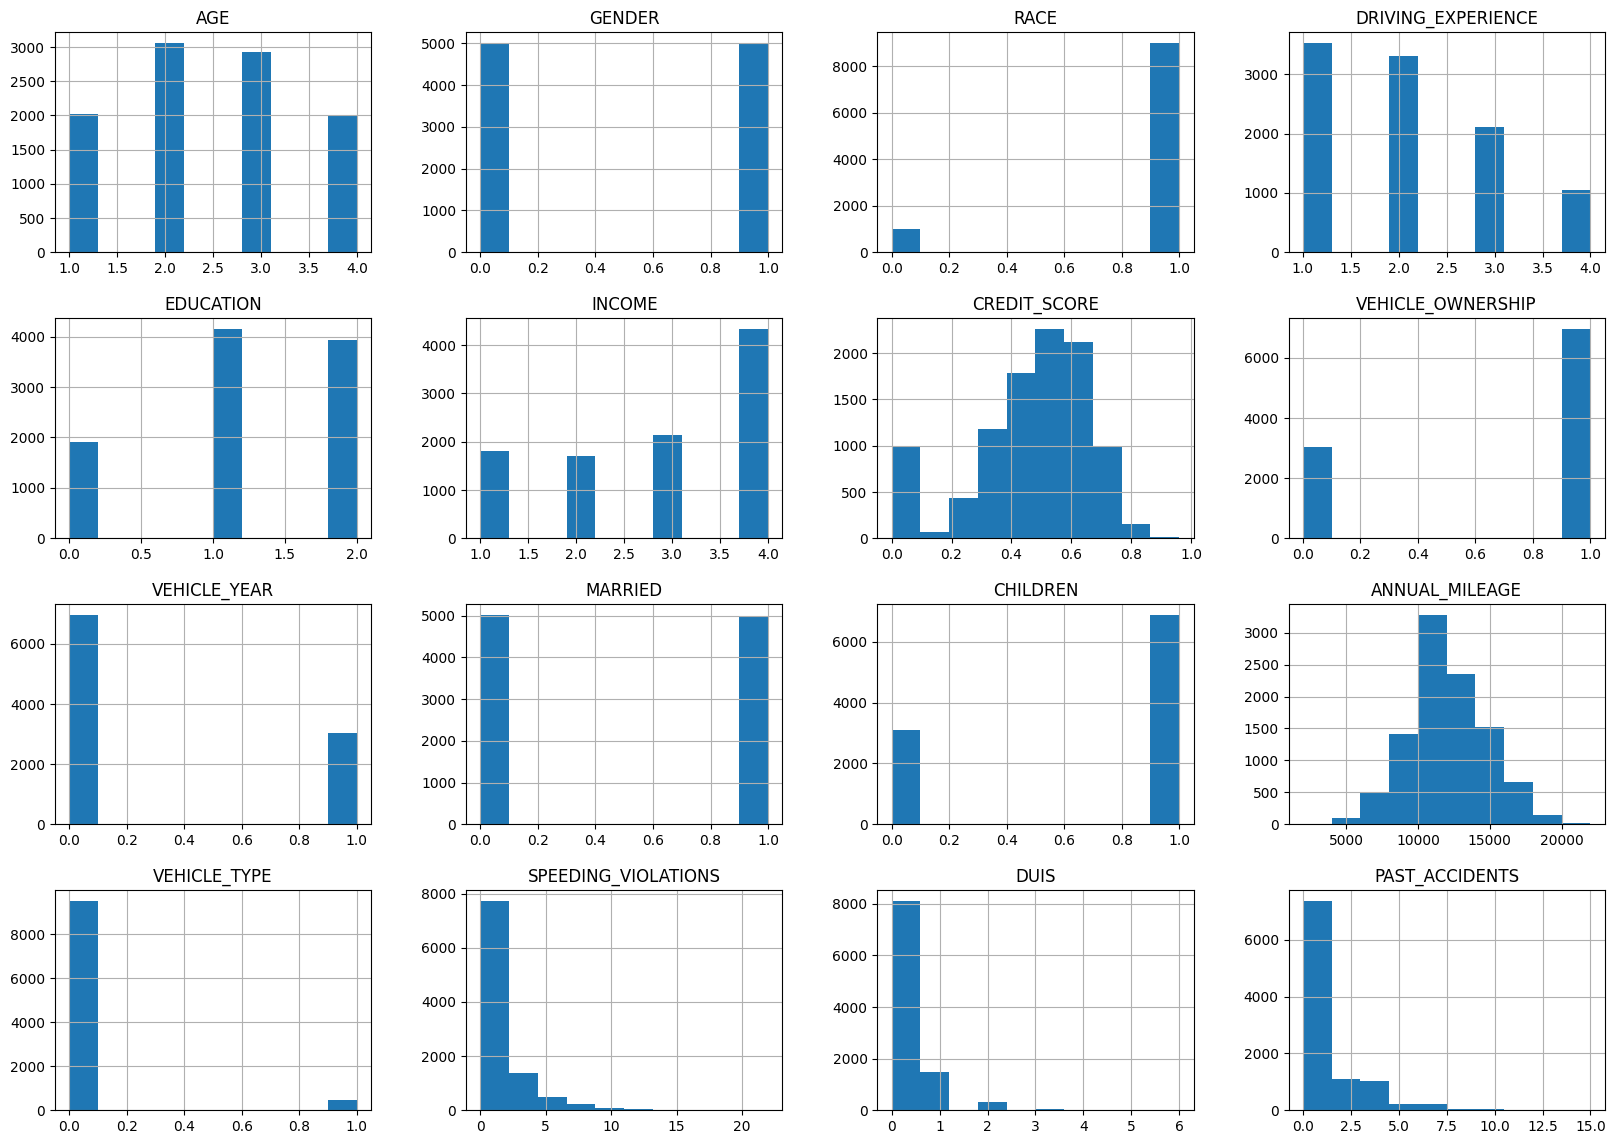

In [24]:
num_columns = cars_insurance_claim.columns[cars_insurance_claim.columns != 'OUTCOME']

cars_insurance_claim[num_columns].hist(figsize=(20, 14))
plt.show()

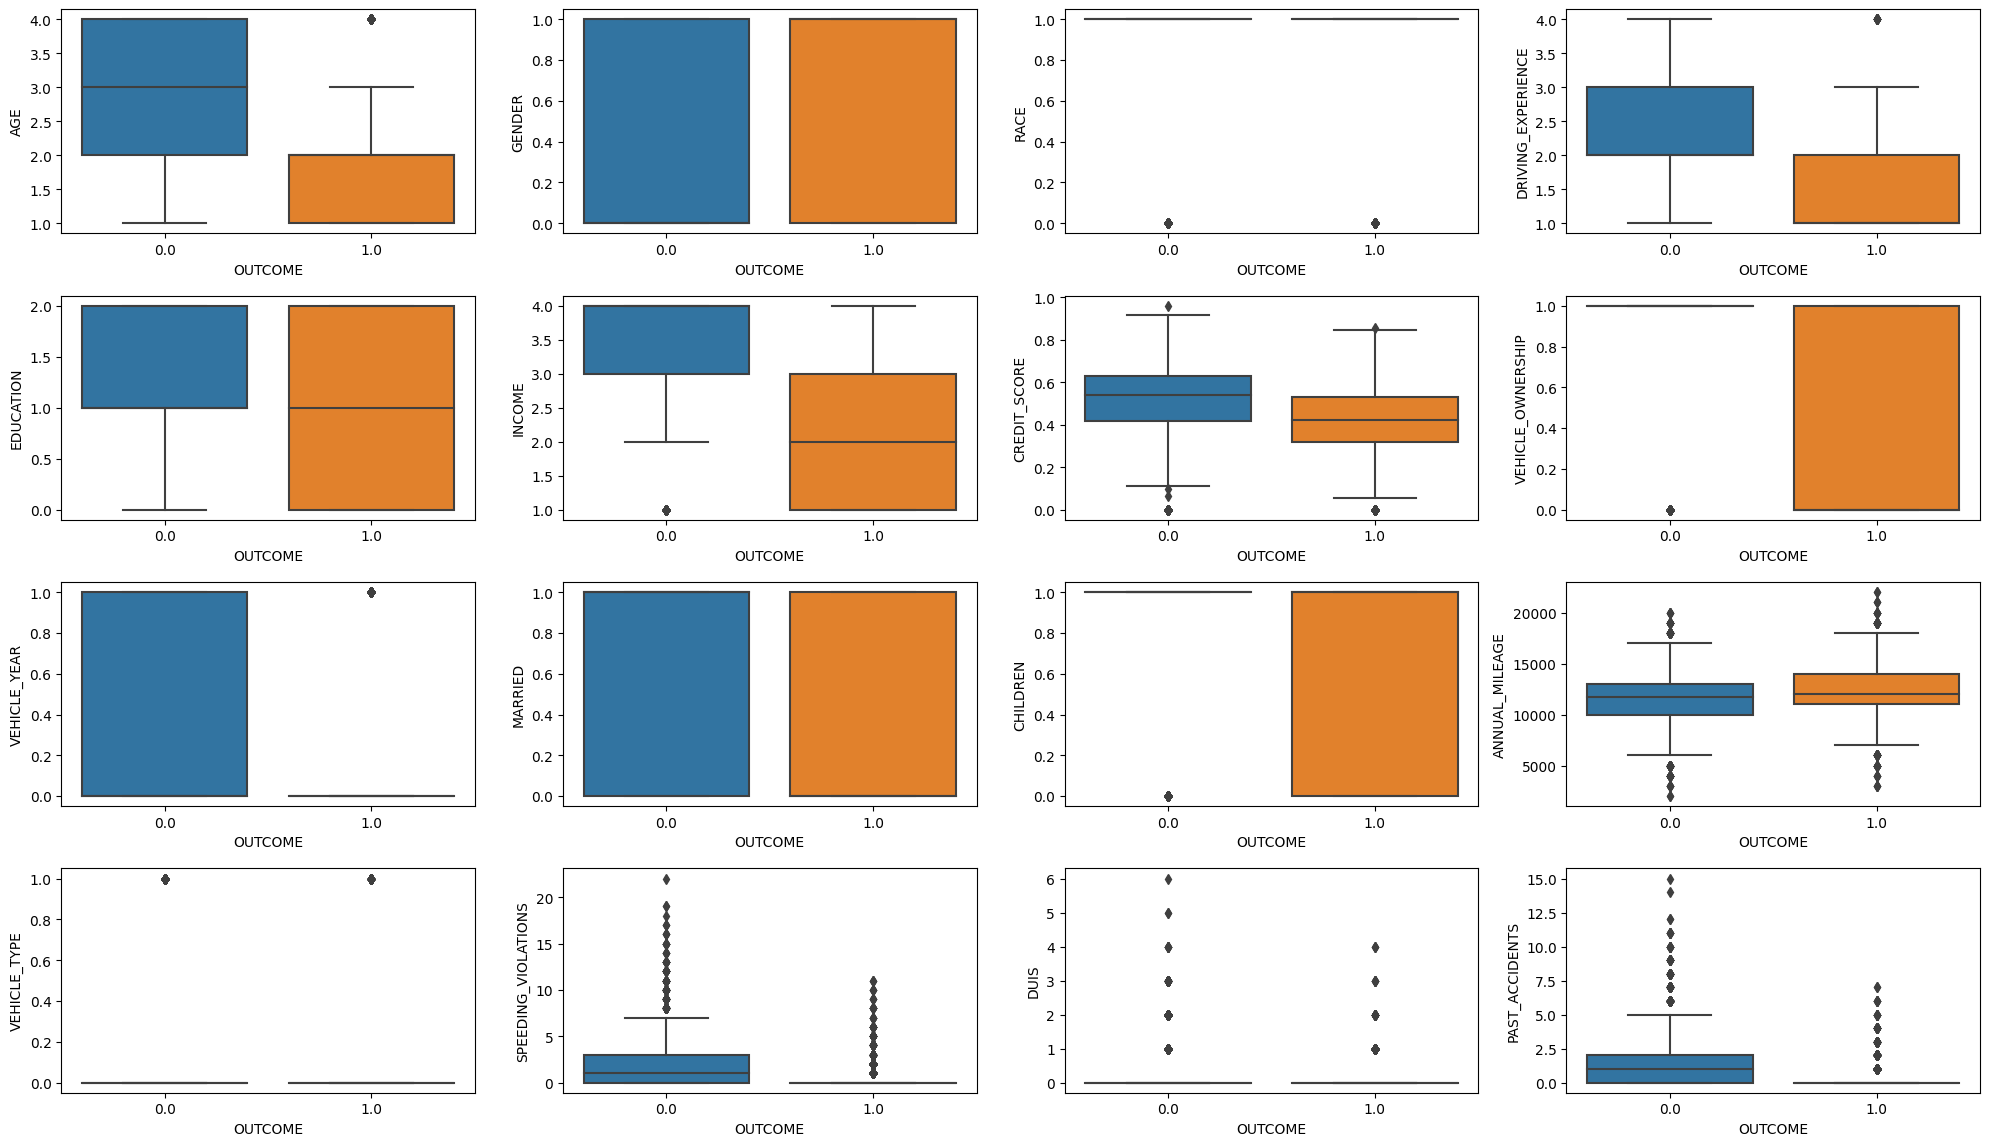

In [25]:
num_columns = cars_insurance_claim.columns[cars_insurance_claim.columns != 'OUTCOME']

plt.figure(figsize=(20, 14))
for i, column in enumerate(num_columns):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(x='OUTCOME', y=column, data=cars_insurance_claim)

plt.tight_layout()
plt.show()

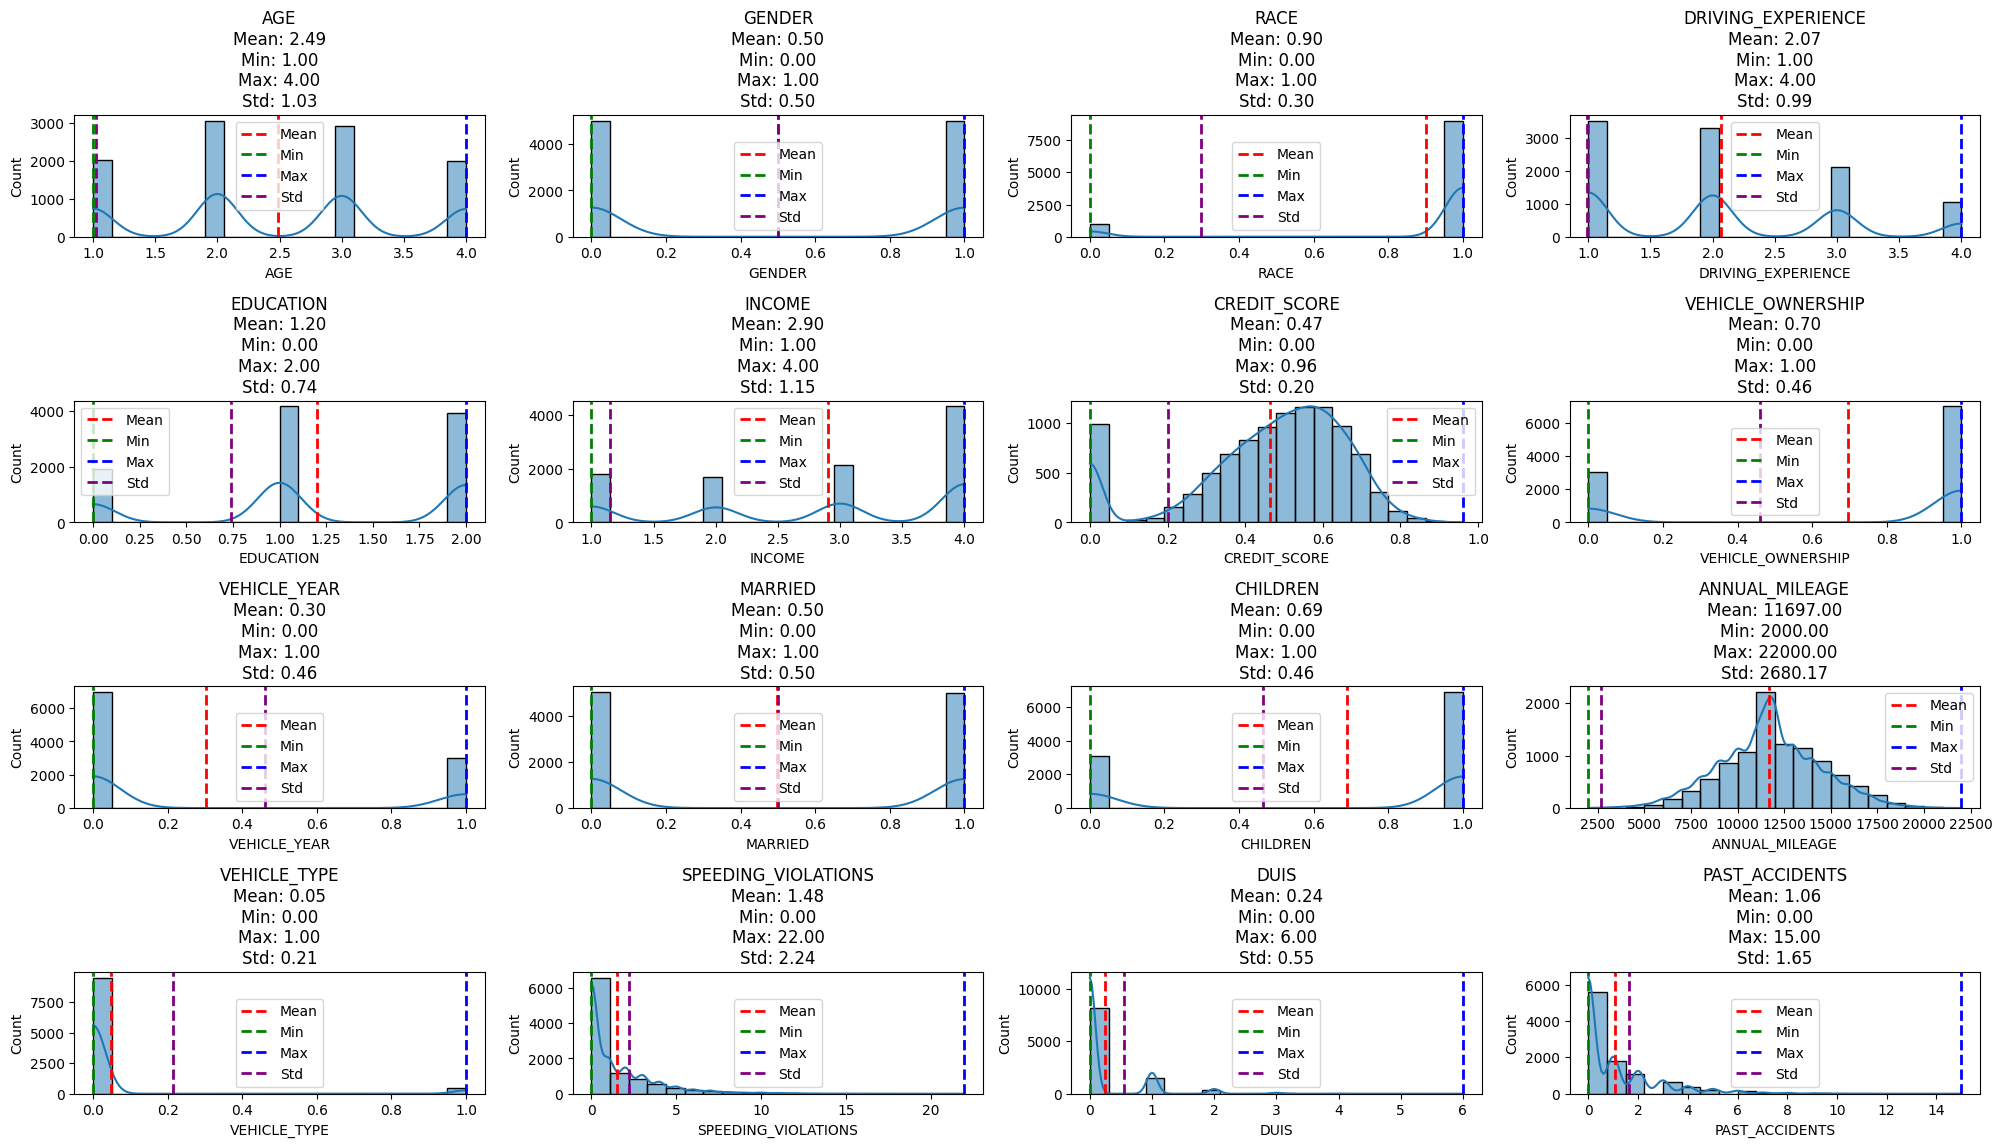

In [26]:
num_columns = cars_insurance_claim.columns[cars_insurance_claim.columns != 'OUTCOME']

stats = cars_insurance_claim[num_columns].describe()

plt.figure(figsize=(20, 14))
for i, column in enumerate(num_columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(cars_insurance_claim[column], kde=True, bins=20)
    plt.title(f"{column}\nMean: {stats[column]['mean']:.2f}\nMin: {stats[column]['min']:.2f}\nMax: {stats[column]['max']:.2f}\nStd: {stats[column]['std']:.2f}")
    plt.axvline(stats[column]['mean'], color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(stats[column]['min'], color='g', linestyle='dashed', linewidth=2, label='Min')
    plt.axvline(stats[column]['max'], color='b', linestyle='dashed', linewidth=2, label='Max')
    plt.axvline(stats[column]['std'], color='purple', linestyle='dashed', linewidth=2, label='Std')
    plt.legend()

plt.tight_layout()
plt.show()

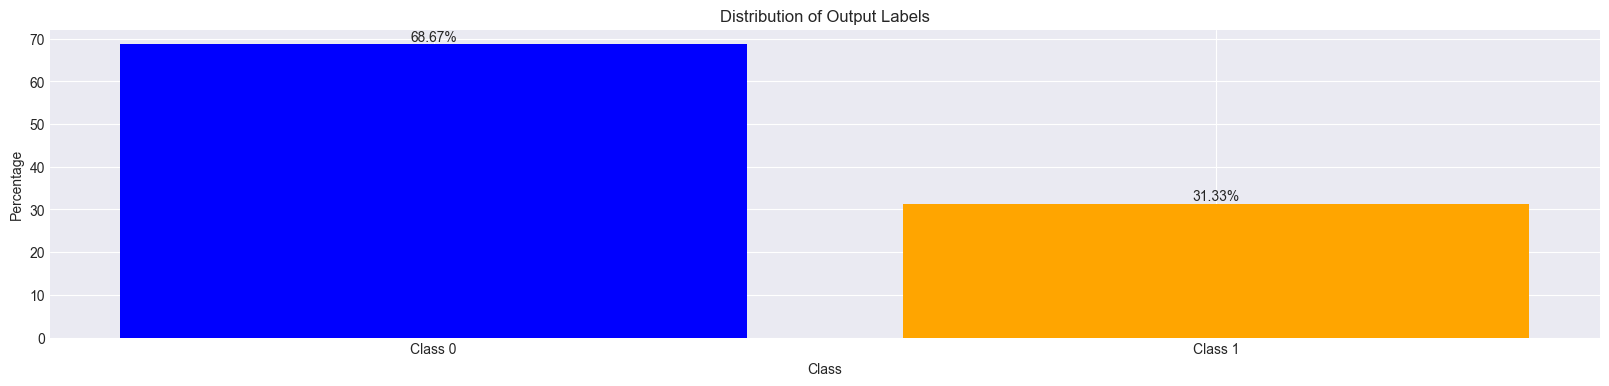

In [27]:
class_distribution = cars_insurance_claim['OUTCOME'].value_counts(normalize=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(20, 4))

bars = plt.bar(class_distribution.index, class_distribution * 100, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Distribution of Output Labels')
plt.xticks(class_distribution.index, ['Class 0', 'Class 1'])

for bar, label in zip(bars, class_distribution * 100):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{label:.2f}%', ha='center', va='bottom')

plt.show()

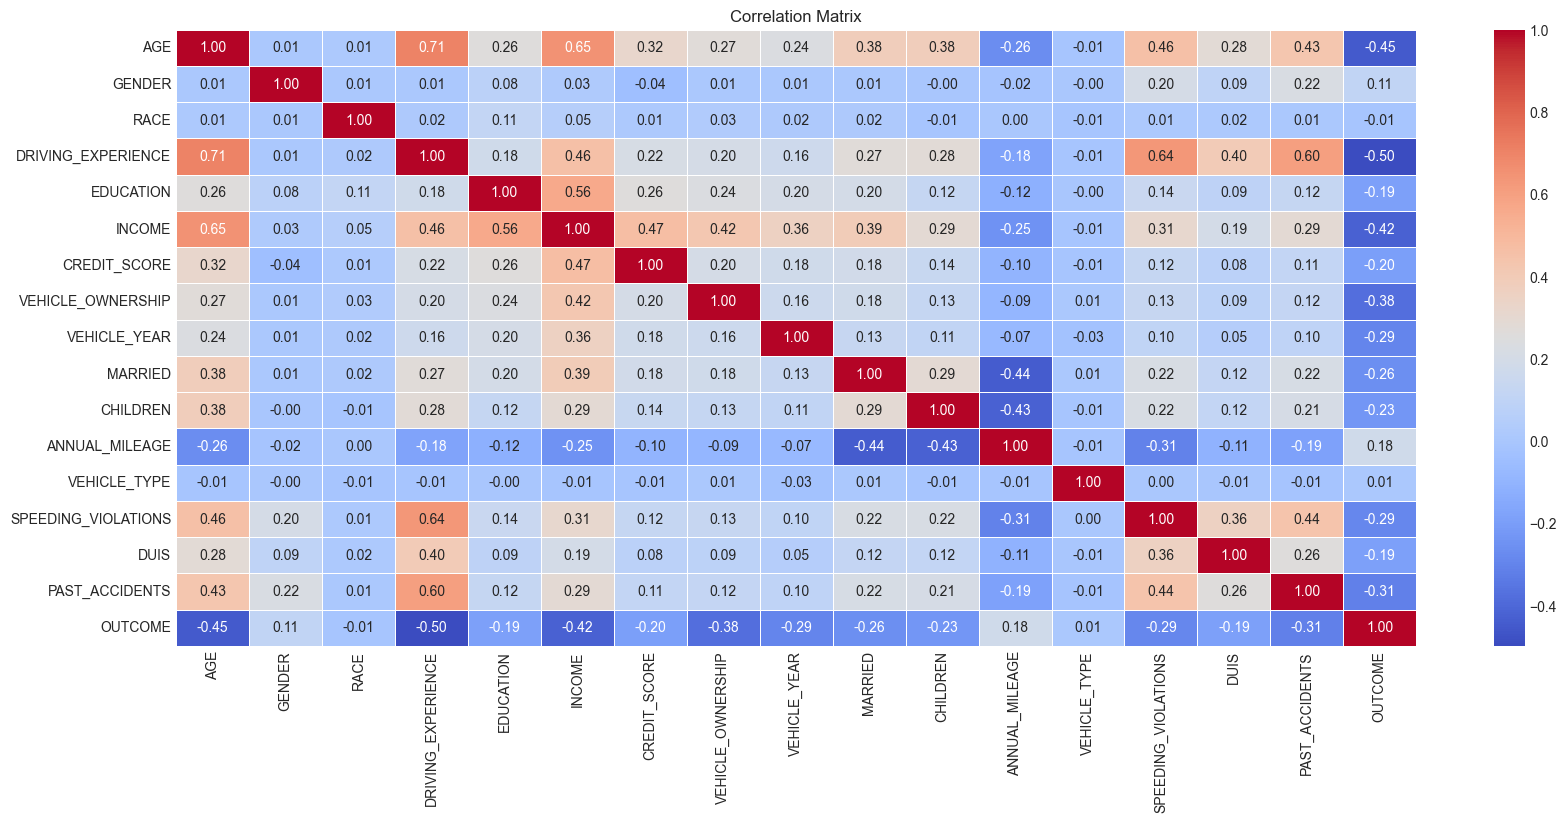

In [28]:
numerical_columns = cars_insurance_claim.select_dtypes(include='number')
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Phase 2: Build a model to overfit the entire dataset

In [29]:
cars_insurance_claim.columns

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED',
       'CHILDREN', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE', 'SPEEDING_VIOLATIONS',
       'DUIS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

In [30]:
X = cars_insurance_claim.drop(columns=['OUTCOME'])
y = cars_insurance_claim['OUTCOME']

In [31]:
def zscore_normalize(data):
    mean_vals = data.mean()
    std_vals = data.std()
    normalized_data = (data - mean_vals) / std_vals
    return normalized_data

normalized_data = zscore_normalize(X)

X = normalized_data

In [32]:
def plot_training_history(model_history, model_name):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label='Training Loss', color='blue', linestyle='-')
    plt.title(f'{model_name} Training - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label='Training Accuracy', color='green', linestyle='--')
    plt.title(f'{model_name} Training - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### MODEL WITH 1 NEURON

In [33]:
model__1 = Sequential()
model__1.add(Dense(1, activation='sigmoid', input_dim=X.shape[1]))

model__1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__1__history = model__1.fit(X, y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
313/313 [==============================] - 1s 1ms/step - loss: 0.5782 - accuracy: 0.7066
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.7641
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.8061
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.4087 - accuracy: 0.8235
Epoch 5/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3946 - accuracy: 0.8281
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3860 - accuracy: 0.8315
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3806 - accuracy: 0.8352
Epoch 8/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3770 - accuracy: 0.8375
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3747 - accuracy: 0.8394
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3729 - accura

313/313 [==============================] - 1s 2ms/step - loss: 0.3678 - accuracy: 0.8416
Epoch 82/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3678 - accuracy: 0.8428
Epoch 83/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3678 - accuracy: 0.8424
Epoch 84/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.8414
Epoch 85/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8423
Epoch 86/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.8418
Epoch 87/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8427
Epoch 88/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3679 - accuracy: 0.8426
Epoch 89/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8419
Epoch 90/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 

In [34]:
model__1__accuracy = model__1__history.history['accuracy'][-1]
print(f'Model 1 Accuracy: {model__1__accuracy*100 :.3f}')

Model 1 Accuracy: 84.200


In [35]:
model__1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


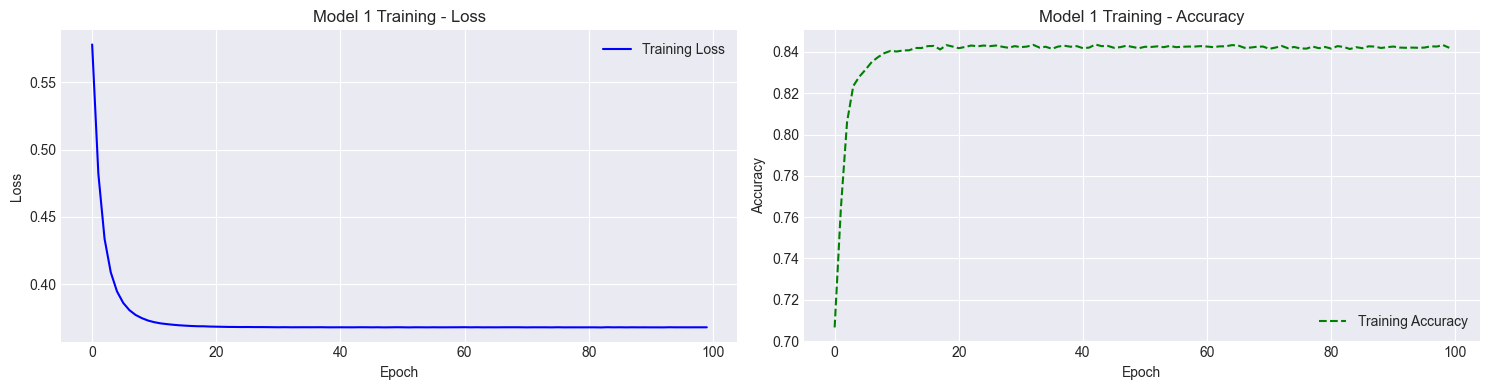

In [36]:
plot_training_history(model__1__history, 'Model 1')

#### MODEL WITH 2 + 1 NEURON

In [37]:
model__2 = Sequential()
model__2.add(Dense(2, activation='relu', input_dim=X.shape[1]))
model__2.add(Dense(1, activation='sigmoid'))

model__2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__2__history = model__2.fit(X, y, epochs=120, batch_size=16, verbose=1)

Epoch 1/120
625/625 [==============================] - 1s 1ms/step - loss: 0.5521 - accuracy: 0.6867
Epoch 2/120
625/625 [==============================] - 1s 1ms/step - loss: 0.4746 - accuracy: 0.7101
Epoch 3/120
625/625 [==============================] - 1s 1ms/step - loss: 0.4431 - accuracy: 0.8064
Epoch 4/120
625/625 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8218
Epoch 5/120
625/625 [==============================] - 1s 1ms/step - loss: 0.4082 - accuracy: 0.8287
Epoch 6/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3995 - accuracy: 0.8317
Epoch 7/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3931 - accuracy: 0.8356
Epoch 8/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3879 - accuracy: 0.8367
Epoch 9/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3841 - accuracy: 0.8397
Epoch 10/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3811 - accura

625/625 [==============================] - 1s 1ms/step - loss: 0.3682 - accuracy: 0.8427
Epoch 82/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3680 - accuracy: 0.8414
Epoch 83/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3680 - accuracy: 0.8410
Epoch 84/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3681 - accuracy: 0.8410
Epoch 85/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3681 - accuracy: 0.8416
Epoch 86/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3680 - accuracy: 0.8421
Epoch 87/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3681 - accuracy: 0.8422
Epoch 88/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3679 - accuracy: 0.8403
Epoch 89/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3683 - accuracy: 0.8412
Epoch 90/120
625/625 [==============================] - 1s 1ms/step - loss: 0.3679 - accuracy: 

In [38]:
model__2__accuracy = model__2__history.history['accuracy'][-1]
print(f'Model 2 Accuracy: {model__2__accuracy*100 :.3f}')

Model 2 Accuracy: 83.980


In [39]:
model__2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


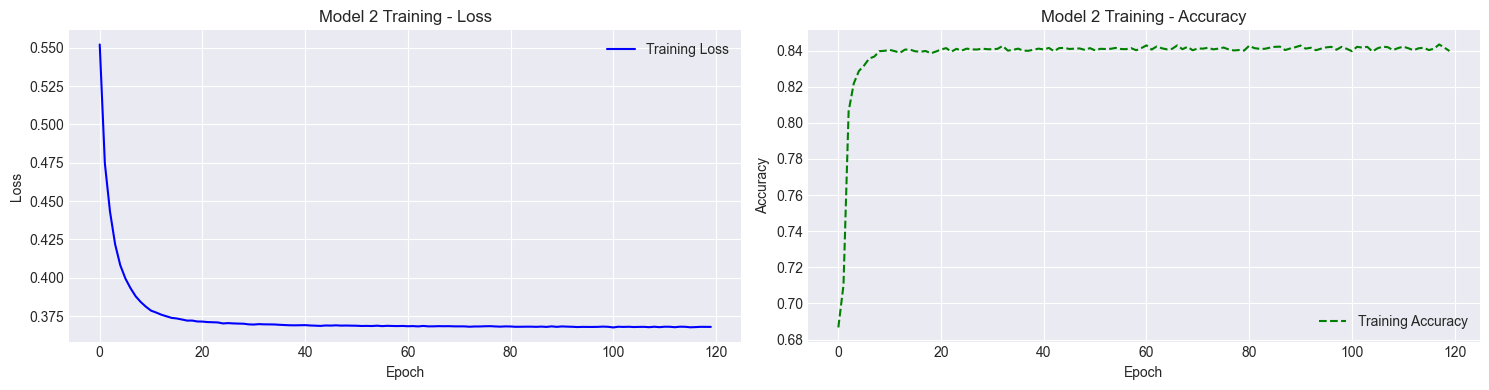

In [40]:
plot_training_history(model__2__history, 'Model 2')

#### MODEL WITH 4 + 2 + 1 NEURON

In [42]:
model__3 = Sequential()
model__3.add(Dense(4, activation='relu'))
model__3.add(Dense(2, activation='relu'))
model__3.add(Dense(1, activation='sigmoid'))

model__3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__3__history = model__3.fit(X, y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 0.5762 - accuracy: 0.6854
Epoch 2/100
313/313 [==============================] - 0s 2ms/step - loss: 0.4865 - accuracy: 0.6867
Epoch 3/100
313/313 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7763
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4346 - accuracy: 0.8253
Epoch 5/100
313/313 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.8270
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4086 - accuracy: 0.8298
Epoch 7/100
313/313 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8304
Epoch 8/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3930 - accuracy: 0.8319
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3878 - accuracy: 0.8338
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3840 - accura

313/313 [==============================] - 0s 1ms/step - loss: 0.3626 - accuracy: 0.8420
Epoch 82/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.8426
Epoch 83/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.8418
Epoch 84/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3622 - accuracy: 0.8404
Epoch 85/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3625 - accuracy: 0.8417
Epoch 86/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3623 - accuracy: 0.8424
Epoch 87/100
313/313 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.8419
Epoch 88/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3625 - accuracy: 0.8418
Epoch 89/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3625 - accuracy: 0.8417
Epoch 90/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3624 - accuracy: 

In [43]:
model__3__accuracy = model__3__history.history['accuracy'][-1]
print(f'Model 3 Accuracy: {model__3__accuracy*100 :.3f}')

Model 3 Accuracy: 84.330


In [44]:
model__3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


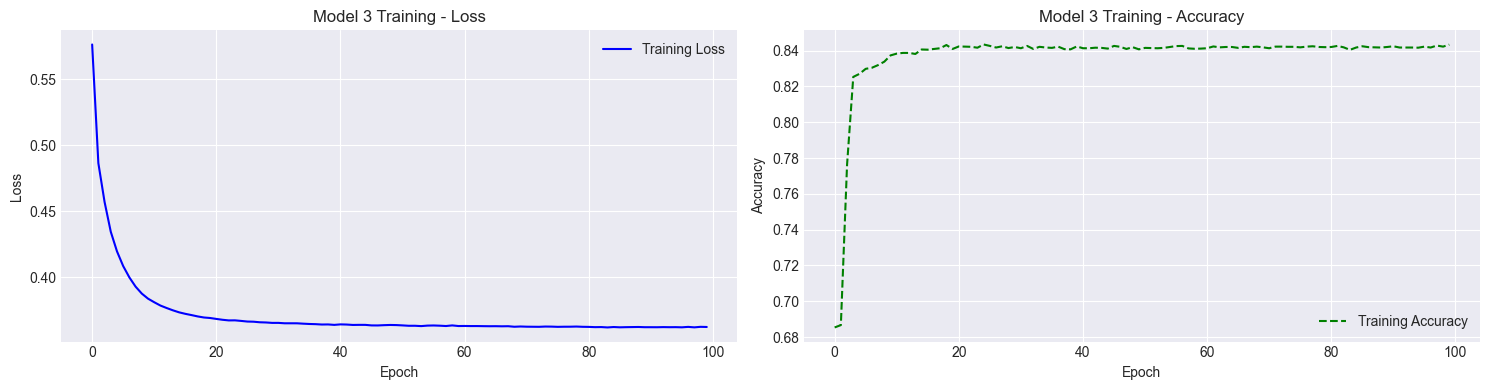

In [45]:
plot_training_history(model__3__history, 'Model 3')

#### MODEL WITH 8 + 4 + 2 + 1 NEURON

In [46]:
model__4 = Sequential()
model__4.add(Dense(8, activation='relu'))
model__4.add(Dense(4, activation='relu'))
model__4.add(Dense(2, activation='relu'))
model__4.add(Dense(1, activation='sigmoid'))

model__4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__4__history = model__4.fit(X, y, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6469 - accuracy: 0.7319
Epoch 2/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4612 - accuracy: 0.8245
Epoch 3/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.4147 - accuracy: 0.8357
Epoch 4/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3940 - accuracy: 0.8386
Epoch 5/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3841 - accuracy: 0.8376
Epoch 6/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3786 - accuracy: 0.8398
Epoch 7/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3743 - accuracy: 0.8423
Epoch 8/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3711 - accuracy: 0.8414
Epoch 9/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.3693 - accuracy: 0.8397
Epoch 10/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.367

In [47]:
model__4_accuracy = model__4__history.history['accuracy'][-1]
print(f'Model 4 Accuracy: {model__4_accuracy*100 :.3f}')

Model 4 Accuracy: 84.300


In [48]:
model__4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (8, 8)                    136       
                                                                 
 dense_7 (Dense)             (8, 4)                    36        
                                                                 
 dense_8 (Dense)             (8, 2)                    10        
                                                                 
 dense_9 (Dense)             (8, 1)                    3         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


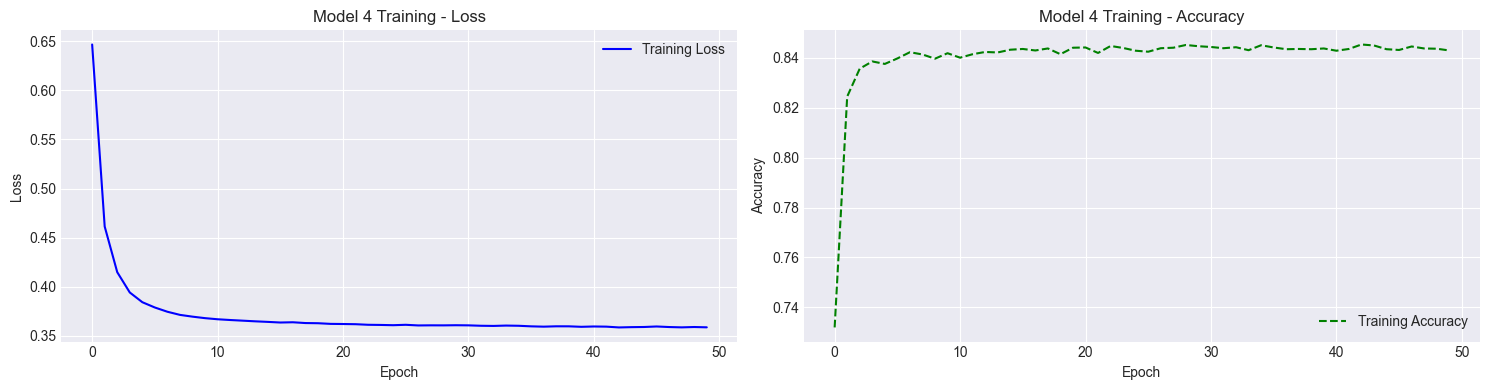

In [49]:
plot_training_history(model__4__history, 'Model 4')

#### MODEL WITH 16 + 8 + 4 + 2 + 1 NEURON

In [50]:
model__5 = Sequential()
model__5.add(Dense(16, activation='relu'))
model__5.add(Dense(8, activation='relu'))
model__5.add(Dense(4, activation='relu'))
model__5.add(Dense(2, activation='relu'))
model__5.add(Dense(1, activation='sigmoid'))

model__5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__5__history = model__5.fit(X, y, epochs=150, batch_size=8, verbose=1)

Epoch 1/150
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6465 - accuracy: 0.6867
Epoch 2/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6232 - accuracy: 0.6867
Epoch 3/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 4/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 5/150
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 6/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 7/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6217 - accuracy: 0.6867
Epoch 8/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 9/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 10/150
1250/1250 [==============================] - 2s 2ms/step - l

1250/1250 [==============================] - 2s 2ms/step - loss: 0.6217 - accuracy: 0.6867
Epoch 80/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 81/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 82/150
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 83/150
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 84/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 85/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 86/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 87/150
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6218 - accuracy: 0.6867
Epoch 88/150
1250/1250 [==============================] - 2s 2ms/step - loss:

In [51]:
model__5__accuracy = model__5__history.history['accuracy'][-1]
print(f'Model 5 Accuracy: {model__5__accuracy*100 :.3f}')

Model 5 Accuracy: 68.670


In [52]:
model__5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (8, 16)                   272       
                                                                 
 dense_11 (Dense)            (8, 8)                    136       
                                                                 
 dense_12 (Dense)            (8, 4)                    36        
                                                                 
 dense_13 (Dense)            (8, 2)                    10        
                                                                 
 dense_14 (Dense)            (8, 1)                    3         
                                                                 
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


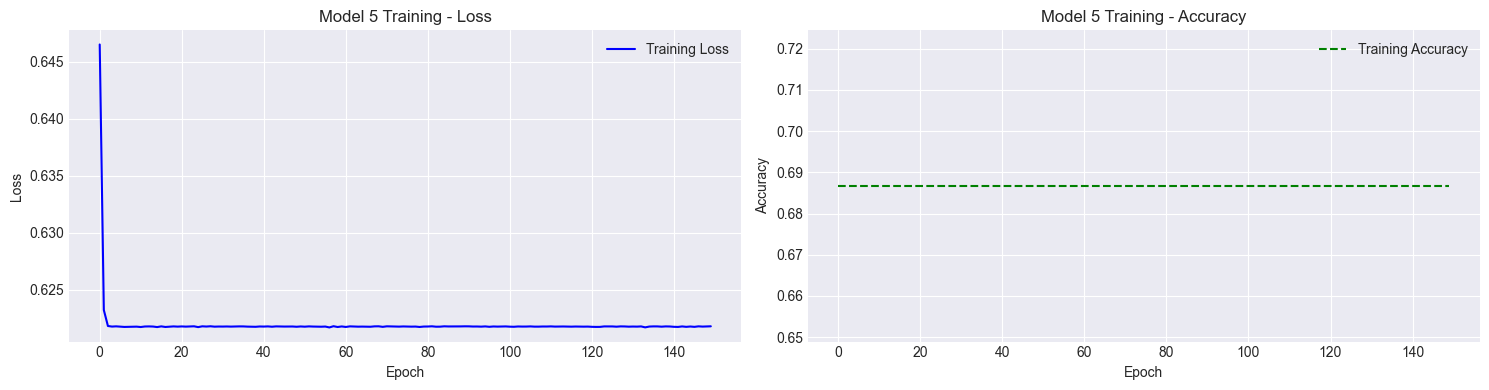

In [53]:
plot_training_history(model__5__history, 'Model 5')

#### MODEL WITH 64 + 32 + 16 + 8 + 4 + 2 + 1 NEURON

In [54]:
model__6 = Sequential()
model__6.add(Dense(64, activation='relu'))
model__6.add(Dense(32, activation='relu'))
model__6.add(Dense(16, activation='relu'))
model__6.add(Dense(8, activation='relu'))
model__6.add(Dense(4, activation='relu'))
model__6.add(Dense(2, activation='relu'))
model__6.add(Dense(1, activation='sigmoid'))

model__6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__6__history = model__6.fit(X, y, epochs=200, batch_size=4, verbose=1)

Epoch 1/200
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4447 - accuracy: 0.7942
Epoch 2/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3927 - accuracy: 0.8369
Epoch 3/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3819 - accuracy: 0.8406
Epoch 4/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3751 - accuracy: 0.8413
Epoch 5/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3706 - accuracy: 0.8442
Epoch 6/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3668 - accuracy: 0.8410
Epoch 7/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3644 - accuracy: 0.8427
Epoch 8/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3615 - accuracy: 0.8437
Epoch 9/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3595 - accuracy: 0.8442
Epoch 10/200
2500/2500 [==============================] - 4s 2ms/step - l

2500/2500 [==============================] - 4s 2ms/step - loss: 0.2187 - accuracy: 0.9050
Epoch 80/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2172 - accuracy: 0.9047
Epoch 81/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2144 - accuracy: 0.9079
Epoch 82/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2141 - accuracy: 0.9062
Epoch 83/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2140 - accuracy: 0.9098
Epoch 84/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2149 - accuracy: 0.9075
Epoch 85/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2125 - accuracy: 0.9079
Epoch 86/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2128 - accuracy: 0.9089
Epoch 87/200
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2133 - accuracy: 0.9075
Epoch 88/200
2500/2500 [==============================] - 4s 2ms/step - loss:

2500/2500 [==============================] - 4s 2ms/step - loss: 0.1638 - accuracy: 0.9328
Epoch 158/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1681 - accuracy: 0.9311
Epoch 159/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1668 - accuracy: 0.9313
Epoch 160/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1712 - accuracy: 0.9294
Epoch 161/200
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1645 - accuracy: 0.9338
Epoch 162/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1715 - accuracy: 0.9311
Epoch 163/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1683 - accuracy: 0.9296
Epoch 164/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1615 - accuracy: 0.9343
Epoch 165/200
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1632 - accuracy: 0.9333
Epoch 166/200
2500/2500 [==============================] - 4s 2ms/ste

In [55]:
model__6__accuracy = model__6__history.history['accuracy'][-1]
print(f'Model 6 Accuracy: {model__6__accuracy*100 :.3f}')

Model 6 Accuracy: 93.540


In [56]:
model__6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (4, 64)                   1088      
                                                                 
 dense_16 (Dense)            (4, 32)                   2080      
                                                                 
 dense_17 (Dense)            (4, 16)                   528       
                                                                 
 dense_18 (Dense)            (4, 8)                    136       
                                                                 
 dense_19 (Dense)            (4, 4)                    36        
                                                                 
 dense_20 (Dense)            (4, 2)                    10        
                                                                 
 dense_21 (Dense)            (4, 1)                   

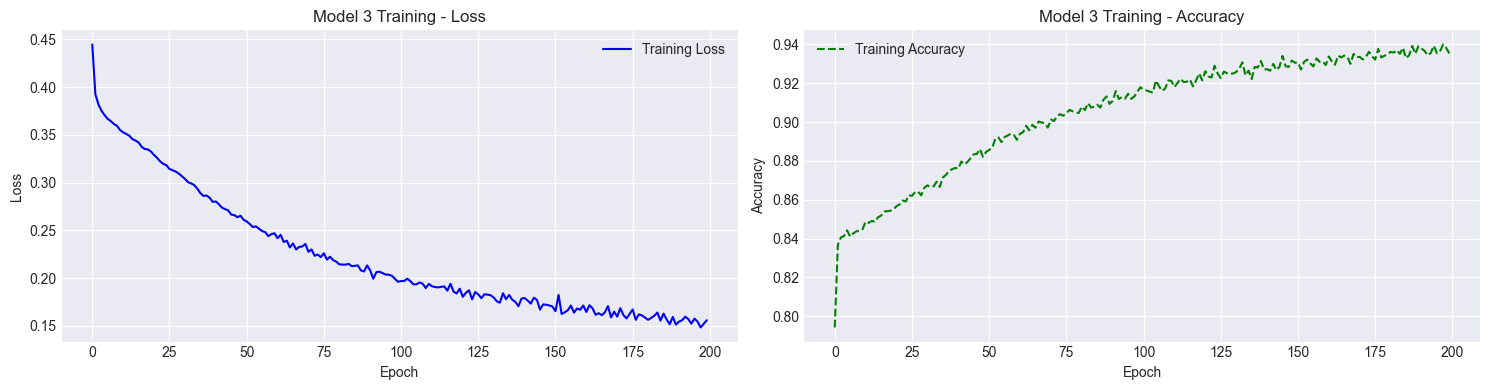

In [57]:
plot_training_history(model__6__history, 'Model 3')

#### MODEL WITH 128 + 64 + 32 + 16 + 8 + 4 + 2 + 1 NEURON

In [58]:
model__7 = Sequential()
model__7.add(Dense(128, activation='relu'))
model__7.add(Dense(64, activation='relu'))
model__7.add(Dense(32, activation='relu'))
model__7.add(Dense(16, activation='relu'))
model__7.add(Dense(8, activation='relu'))
model__7.add(Dense(4, activation='relu'))
model__7.add(Dense(2, activation='relu'))
model__7.add(Dense(1, activation='sigmoid'))

model__7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model__7__history = model__7.fit(X, y, epochs=500, batch_size=4, verbose=1)

Epoch 1/500
2500/2500 [==============================] - 6s 2ms/step - loss: 0.5153 - accuracy: 0.8188
Epoch 2/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4088 - accuracy: 0.8365
Epoch 3/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3857 - accuracy: 0.8386
Epoch 4/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3755 - accuracy: 0.8397
Epoch 5/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3725 - accuracy: 0.8426
Epoch 6/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3699 - accuracy: 0.8414
Epoch 7/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3672 - accuracy: 0.8422
Epoch 8/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3677 - accuracy: 0.8439
Epoch 9/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3649 - accuracy: 0.8439
Epoch 10/500
2500/2500 [==============================] - 5s 2ms/step - l

2500/2500 [==============================] - 5s 2ms/step - loss: 0.2485 - accuracy: 0.9058
Epoch 80/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2531 - accuracy: 0.9041
Epoch 81/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2572 - accuracy: 0.9032
Epoch 82/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2588 - accuracy: 0.9066
Epoch 83/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2454 - accuracy: 0.9092
Epoch 84/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2482 - accuracy: 0.9058
Epoch 85/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2502 - accuracy: 0.9086
Epoch 86/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2441 - accuracy: 0.9089
Epoch 87/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2396 - accuracy: 0.9094
Epoch 88/500
2500/2500 [==============================] - 5s 2ms/step - loss:

2500/2500 [==============================] - 4s 2ms/step - loss: 0.1996 - accuracy: 0.9338
Epoch 158/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2024 - accuracy: 0.9325
Epoch 159/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1989 - accuracy: 0.9325
Epoch 160/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1949 - accuracy: 0.9356
Epoch 161/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1955 - accuracy: 0.9341
Epoch 162/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1935 - accuracy: 0.9357
Epoch 163/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.2040 - accuracy: 0.9311
Epoch 164/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1939 - accuracy: 0.9337
Epoch 165/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1982 - accuracy: 0.9334
Epoch 166/500
2500/2500 [==============================] - 4s 2ms/ste

2500/2500 [==============================] - 4s 2ms/step - loss: 0.1823 - accuracy: 0.9390
Epoch 236/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1863 - accuracy: 0.9396
Epoch 237/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1731 - accuracy: 0.9437
Epoch 238/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1793 - accuracy: 0.9438
Epoch 239/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1806 - accuracy: 0.9421
Epoch 240/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1771 - accuracy: 0.9452
Epoch 241/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1786 - accuracy: 0.9441
Epoch 242/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1789 - accuracy: 0.9425
Epoch 243/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1675 - accuracy: 0.9467
Epoch 244/500
2500/2500 [==============================] - 4s 2ms/ste

2500/2500 [==============================] - 5s 2ms/step - loss: 0.1641 - accuracy: 0.9496
Epoch 314/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1619 - accuracy: 0.9488
Epoch 315/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1661 - accuracy: 0.9481
Epoch 316/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1591 - accuracy: 0.9510
Epoch 317/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1624 - accuracy: 0.9498
Epoch 318/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1612 - accuracy: 0.9514
Epoch 319/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1602 - accuracy: 0.9493
Epoch 320/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1603 - accuracy: 0.9499
Epoch 321/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1652 - accuracy: 0.9502
Epoch 322/500
2500/2500 [==============================] - 4s 2ms/ste

2500/2500 [==============================] - 4s 2ms/step - loss: 0.1516 - accuracy: 0.9544
Epoch 392/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1690 - accuracy: 0.9513
Epoch 393/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1603 - accuracy: 0.9524
Epoch 394/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1567 - accuracy: 0.9537
Epoch 395/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1628 - accuracy: 0.9515
Epoch 396/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1567 - accuracy: 0.9524
Epoch 397/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1597 - accuracy: 0.9525
Epoch 398/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1593 - accuracy: 0.9525
Epoch 399/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1620 - accuracy: 0.9505
Epoch 400/500
2500/2500 [==============================] - 4s 2ms/ste

2500/2500 [==============================] - 4s 2ms/step - loss: 0.1486 - accuracy: 0.9556
Epoch 470/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1474 - accuracy: 0.9558
Epoch 471/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1601 - accuracy: 0.9521
Epoch 472/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1608 - accuracy: 0.9526
Epoch 473/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1606 - accuracy: 0.9534
Epoch 474/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1766 - accuracy: 0.9482
Epoch 475/500
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1733 - accuracy: 0.9492
Epoch 476/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1732 - accuracy: 0.9485
Epoch 477/500
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1583 - accuracy: 0.9530
Epoch 478/500
2500/2500 [==============================] - 5s 2ms/ste

In [59]:
model__7__accuracy = model__7__history.history['accuracy'][-1]
print(f'Model 7 Accuracy: {model__7__accuracy*100 :.3f}')

Model 7 Accuracy: 94.990


In [60]:
model__7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (4, 128)                  2176      
                                                                 
 dense_23 (Dense)            (4, 64)                   8256      
                                                                 
 dense_24 (Dense)            (4, 32)                   2080      
                                                                 
 dense_25 (Dense)            (4, 16)                   528       
                                                                 
 dense_26 (Dense)            (4, 8)                    136       
                                                                 
 dense_27 (Dense)            (4, 4)                    36        
                                                                 
 dense_28 (Dense)            (4, 2)                   

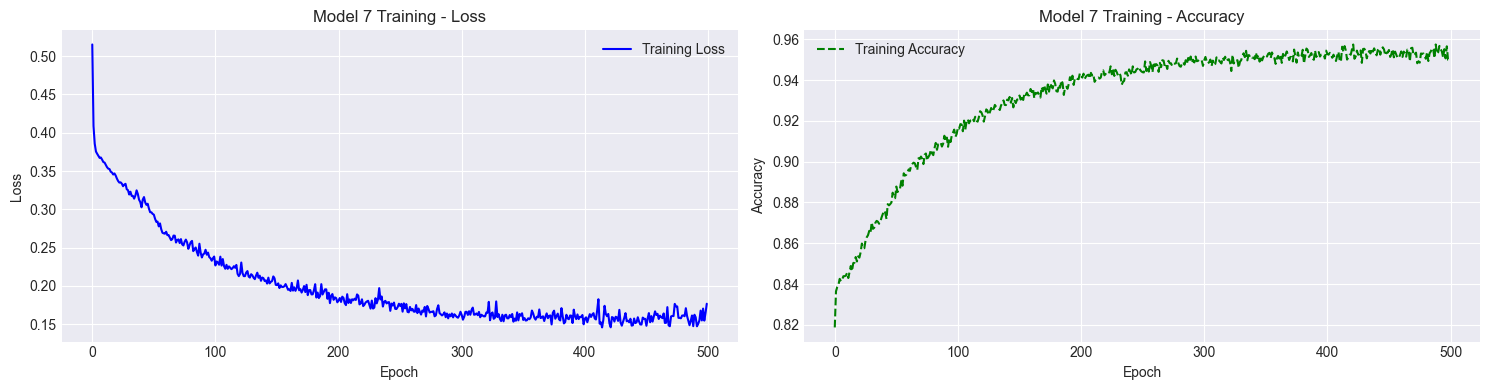

In [61]:
plot_training_history(model__7__history, 'Model 7')

### Phase 3: Model Selection and Evaluation

In [62]:
X = cars_insurance_claim.drop(columns=['OUTCOME'])
y = cars_insurance_claim['OUTCOME']

In [63]:
def zscore_normalize(data):
    mean_vals = data.mean()
    std_vals = data.std()
    normalized_data = (data - mean_vals) / std_vals
    return normalized_data

normalized_data = zscore_normalize(X)

X = normalized_data

In [64]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:
shuffled_indices = np.random.permutation(X.index)
X_shuffled = X.reindex(shuffled_indices)
y_shuffled = y.reindex(shuffled_indices)

In [66]:
split_ratio = 0.8
split_index = int(split_ratio * len(X_shuffled))

In [67]:
X_train, X_val = X_shuffled.iloc[:split_index], X_shuffled.iloc[split_index:]
y_train, y_val = y_shuffled.iloc[:split_index], y_shuffled.iloc[split_index:]

In [68]:
logistic_regression_model = LogisticRegression()

logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_val)

logistic_regression_accuracy = accuracy_score(y_val, y_pred)
classification_report_str = classification_report(y_val, y_pred)

print(f"Accuracy: {logistic_regression_accuracy:.2%}")
print("\nClassification Report:\n", classification_report_str)

Accuracy: 84.40%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1392
         1.0       0.77      0.70      0.73       608

    accuracy                           0.84      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.84      0.84      0.84      2000



##### Random Baseline Classifier Model

In [69]:
random_baseline_model = DummyClassifier(strategy='stratified', random_state=42)

random_baseline_model.fit(X_train, y_train)

y_pred_random = random_baseline_model.predict(X_val)

random_baseline_accuracy = accuracy_score(y_val, y_pred_random)
classification_report_random = classification_report(y_val, y_pred_random)

print(f"Random Baseline Classifier Accuracy: {random_baseline_accuracy:.2%}")
print("\nClassification Report:\n", classification_report_random)

Random Baseline Classifier Accuracy: 57.35%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.69      0.69      1392
         1.0       0.31      0.32      0.31       608

    accuracy                           0.57      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.58      0.57      0.58      2000



##### Random Forest Classifier Model

In [70]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_val)

random_forest_accuracy = accuracy_score(y_val, y_pred)
classification_report_str = classification_report(y_val, y_pred)

print(f"Accuracy: {random_forest_accuracy:.2%}")
print("\nClassification Report:\n", classification_report_str)

Accuracy: 84.00%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1392
         1.0       0.77      0.68      0.72       608

    accuracy                           0.84      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.84      0.84      0.84      2000



#### MODEL WITH 1 NEURON

In [71]:
model_1 = Sequential()

model_1.add(Dense(1, activation='sigmoid', input_dim=X_train.shape[1]))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_checkpoint = ModelCheckpoint('model_1.h5', save_best_only=True)

model_1_history = model_1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_1_checkpoint])

Epoch 1/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7245 - accuracy: 0.6019 - val_loss: 0.6047 - val_accuracy: 0.6890
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 0.5595 - accuracy: 0.7156 - val_loss: 0.5073 - val_accuracy: 0.7560
Epoch 3/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4892 - accuracy: 0.7590 - val_loss: 0.4548 - val_accuracy: 0.7860
Epoch 4/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7915 - val_loss: 0.4235 - val_accuracy: 0.8040
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.4211 - accuracy: 0.8129 - val_loss: 0.4040 - val_accuracy: 0.8205
Epoch 6/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4047 - accuracy: 0.8234 - val_loss: 0.3915 - val_accuracy: 0.8300
Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.3939 - accuracy: 0.8289 - val_loss: 0.3833 - val_accuracy: 0.8370
Epoch 

In [72]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [73]:
training_accuracy = model_1_history.history['accuracy']
validation_accuracy = model_1_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 84.0625
Validation Accuracy: 84.3500


In [74]:
model_1_y_pred = (model_1.predict(X_val) > 0.5).astype(int)
model_1_accuracy = accuracy_score(y_val, model_1_y_pred)
model_1_classification_report_str = classification_report(y_val, model_1_y_pred)

print(f"Accuracy: {model_1_accuracy :.2%}")
print("\nClassification Report:\n", model_1_classification_report_str)

63/63 [==============================] - 0s 1ms/step
Accuracy: 84.35%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1392
         1.0       0.77      0.70      0.73       608

    accuracy                           0.84      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.84      0.84      0.84      2000



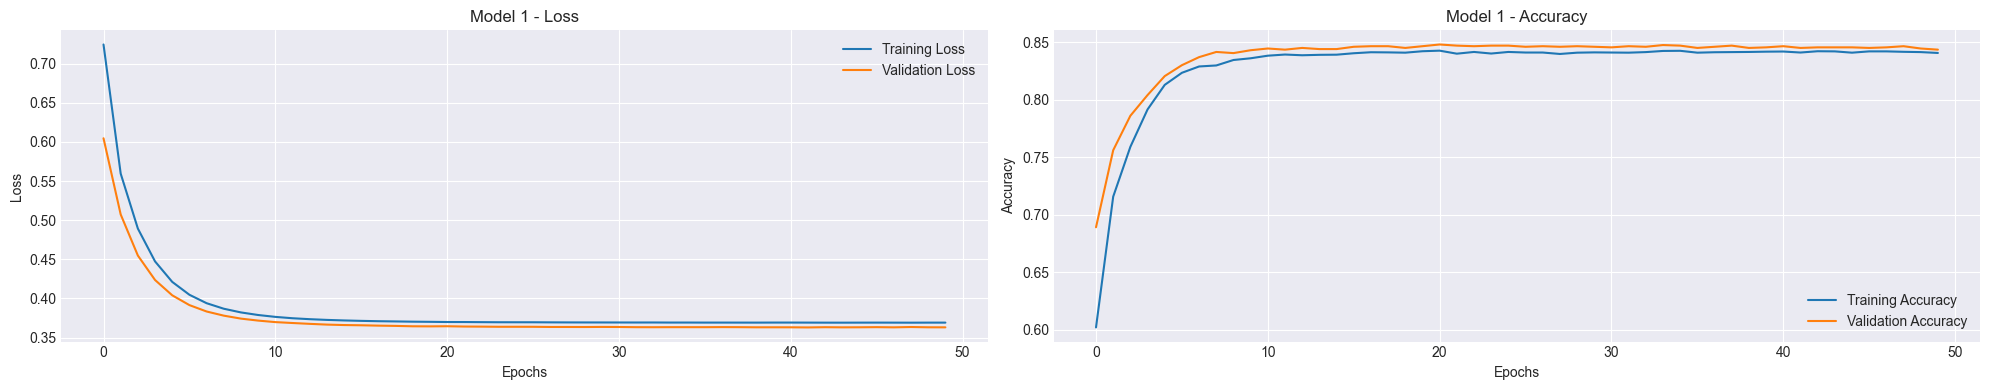

In [75]:
plot_learning_curves(model_1_history, 'Model 1')

#### MODEL WITH 2 + 1 NEURON

In [76]:
model_2 = Sequential()
model_2.add(Dense(2, activation='relu', input_dim=X.shape[1]))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_2_checkpoint = ModelCheckpoint('model_2.h5', save_best_only=True)

model_2_history = model_2.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_2_checkpoint])

Epoch 1/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5821 - accuracy: 0.6820 - val_loss: 0.5250 - val_accuracy: 0.6960
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5059 - accuracy: 0.6844 - val_loss: 0.4754 - val_accuracy: 0.6960
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4682 - accuracy: 0.7765 - val_loss: 0.4441 - val_accuracy: 0.8020
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4425 - accuracy: 0.8024 - val_loss: 0.4236 - val_accuracy: 0.8125
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4244 - accuracy: 0.8121 - val_loss: 0.4108 - val_accuracy: 0.8225
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4132 - accuracy: 0.8209 - val_loss: 0.4029 - val_accuracy: 0.8275
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4060 - accuracy: 0.8245 - val_loss: 0.3966 - val_accuracy: 0.8295
Epoch 

In [77]:
training_accuracy = model_2_history.history['accuracy']
validation_accuracy = model_2_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 83.9625
Validation Accuracy: 84.4000


In [78]:
model_2_y_pred = (model_2.predict(X_val) > 0.5).astype(int)
model_2_accuracy = accuracy_score(y_val, model_2_y_pred)
model_2_classification_report_str = classification_report(y_val, model_2_y_pred)

print(f"Accuracy: {model_2_accuracy :.2%}")
print("\nClassification Report:\n", model_2_classification_report_str)

63/63 [==============================] - 0s 2ms/step
Accuracy: 84.40%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1392
         1.0       0.78      0.69      0.73       608

    accuracy                           0.84      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.84      0.84      0.84      2000



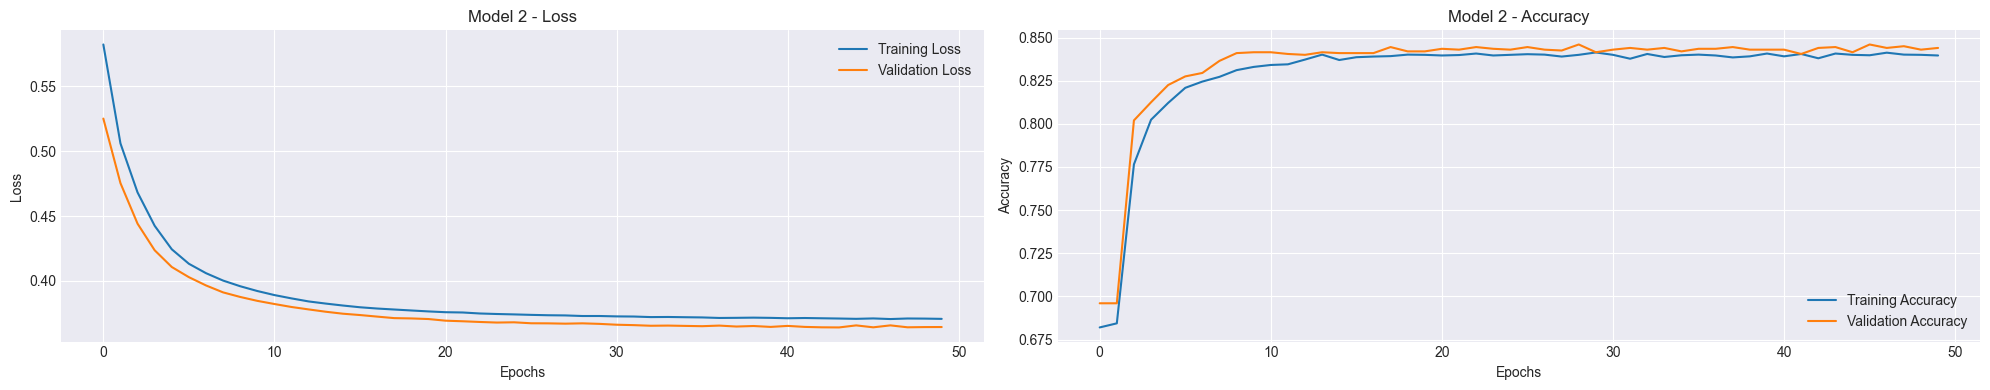

In [79]:
plot_learning_curves(model_2_history, 'Model 2')

#### MODEL WITH 4 + 2 + 1 NEURON

In [80]:
model_3 = Sequential()
model_3.add(Dense(4, activation='relu', input_dim=X.shape[1]))
model_3.add(Dense(2, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_3_checkpoint = ModelCheckpoint('model_3.h5', save_best_only=True)

model_3_history = model_3.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_3_checkpoint])

Epoch 1/100
500/500 [==============================] - 2s 2ms/step - loss: 0.5304 - accuracy: 0.7542 - val_loss: 0.4417 - val_accuracy: 0.8070
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 0.4243 - accuracy: 0.8129 - val_loss: 0.4000 - val_accuracy: 0.8200
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3952 - accuracy: 0.8239 - val_loss: 0.3832 - val_accuracy: 0.8265
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3825 - accuracy: 0.8295 - val_loss: 0.3746 - val_accuracy: 0.8370
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3763 - accuracy: 0.8338 - val_loss: 0.3706 - val_accuracy: 0.8440
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3730 - accuracy: 0.8349 - val_loss: 0.3688 - val_accuracy: 0.8430
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3708 - accuracy: 0.8371 - val_loss: 0.3667 - val_accuracy: 0.8460

Epoch 58/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3601 - accuracy: 0.8407 - val_loss: 0.3653 - val_accuracy: 0.8455
Epoch 59/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3604 - accuracy: 0.8406 - val_loss: 0.3654 - val_accuracy: 0.8440
Epoch 60/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3603 - accuracy: 0.8409 - val_loss: 0.3652 - val_accuracy: 0.8465
Epoch 61/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3605 - accuracy: 0.8405 - val_loss: 0.3660 - val_accuracy: 0.8455
Epoch 62/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3602 - accuracy: 0.8403 - val_loss: 0.3650 - val_accuracy: 0.8465
Epoch 63/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3601 - accuracy: 0.8399 - val_loss: 0.3651 - val_accuracy: 0.8475
Epoch 64/100
500/500 [==============================] - 1s 2ms/step - loss: 0.3601 - accuracy: 0.8403 - val_loss: 0.3668 - val_accuracy:

In [81]:
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4)                 68        
                                                                 
 dense_34 (Dense)            (None, 2)                 10        
                                                                 
 dense_35 (Dense)            (None, 1)                 3         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [82]:
training_accuracy = model_3_history.history['accuracy']
validation_accuracy = model_3_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 84.1000
Validation Accuracy: 84.5000


In [83]:
model_3_y_pred = (model_3.predict(X_val) > 0.5).astype(int)
model_3_accuracy = accuracy_score(y_val, model_3_y_pred)
model_3_classification_report_str = classification_report(y_val, model_3_y_pred)

print(f"Accuracy: {model_3_accuracy :.2%}")
print("\nClassification Report:\n", model_3_classification_report_str)

63/63 [==============================] - 0s 1ms/step
Accuracy: 84.50%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1392
         1.0       0.77      0.70      0.73       608

    accuracy                           0.84      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.84      0.84      0.84      2000



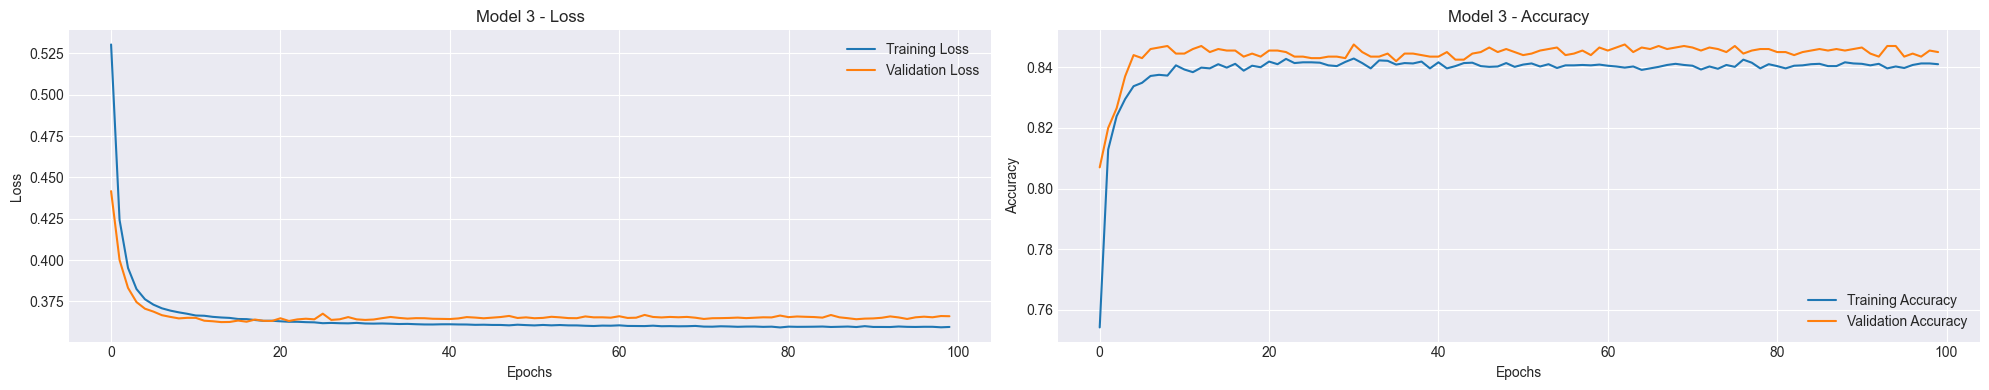

In [84]:
plot_learning_curves(model_3_history, 'Model 3')

#### MODEL WITH 8 + 4 + 2 + 1 NEURON

In [85]:
model_4 = Sequential()
model_4.add(Dense(4, activation='relu', input_dim=X.shape[1]))
model_4.add(Dense(2, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_4_checkpoint = ModelCheckpoint('model_4.h5', save_best_only=True)

model_4_history = model_4.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), callbacks=[model_4_checkpoint])

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5044 - accuracy: 0.7289 - val_loss: 0.4302 - val_accuracy: 0.8125
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4071 - accuracy: 0.8206 - val_loss: 0.3874 - val_accuracy: 0.8340
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3838 - accuracy: 0.8294 - val_loss: 0.3755 - val_accuracy: 0.8350
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3767 - accuracy: 0.8353 - val_loss: 0.3704 - val_accuracy: 0.8395
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3724 - accuracy: 0.8382 - val_loss: 0.3667 - val_accuracy: 0.8390
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3701 - accuracy: 0.8361 - val_loss: 0.3663 - val_accuracy: 0.8410
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3685 - accuracy: 0.8375 - val_loss: 0.3650 - val_accuracy:

In [86]:
model_4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 4)                 68        
                                                                 
 dense_37 (Dense)            (None, 2)                 10        
                                                                 
 dense_38 (Dense)            (None, 1)                 3         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [87]:
training_accuracy = model_4_history.history['accuracy']
validation_accuracy = model_4_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 84.0000
Validation Accuracy: 84.4500


In [88]:
model_4_y_pred = (model_4.predict(X_val) > 0.5).astype(int)
model_4_accuracy = accuracy_score(y_val, model_4_y_pred)
model_4_classification_report_str = classification_report(y_val, model_4_y_pred)

print(f"Accuracy: {model_4_accuracy :.2%}")
print("\nClassification Report:\n", model_4_classification_report_str)

63/63 [==============================] - 0s 1ms/step
Accuracy: 84.45%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1392
         1.0       0.77      0.70      0.73       608

    accuracy                           0.84      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.84      0.84      0.84      2000



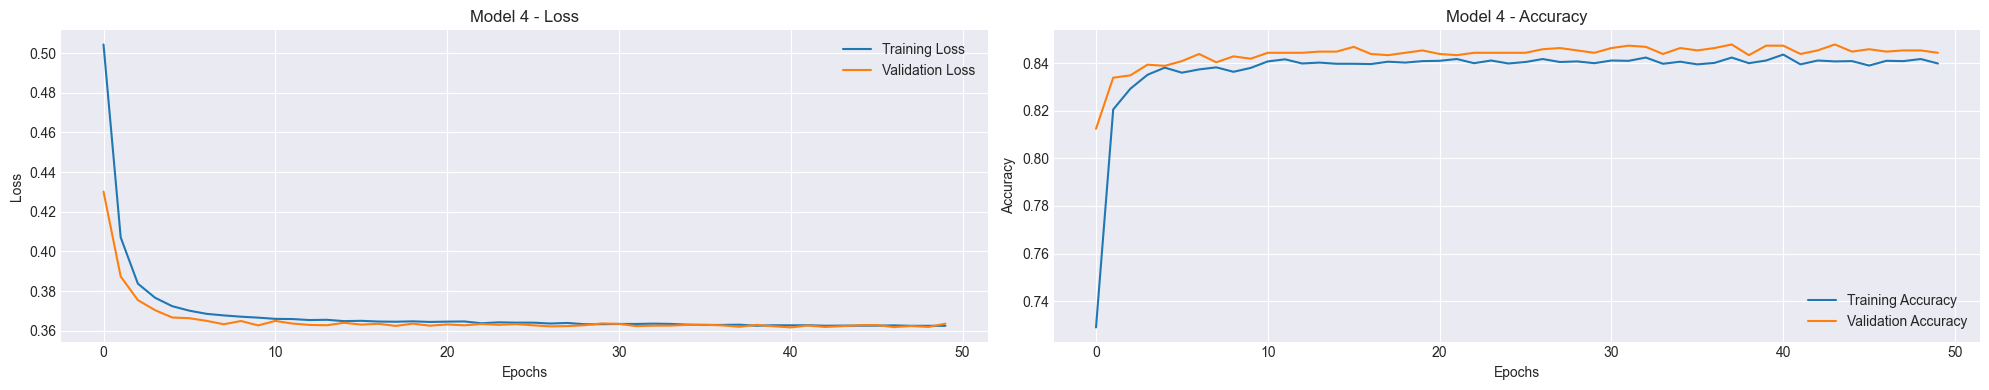

In [89]:
plot_learning_curves(model_4_history, 'Model 4')

#### MODEL WITH 16 + 8 + 4 + 2 + 1 NEURON

In [90]:
model_5 = Sequential()
model_5.add(Dense(16, activation='relu', input_dim=X.shape[1]))
model_5.add(Dense(8, activation='relu'))
model_5.add(Dense(4, activation='relu'))
model_5.add(Dense(2, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_5_checkpoint = ModelCheckpoint('model_5.h5', save_best_only=True)

model_5_history = model_5.fit(X_train, y_train, epochs=150, batch_size=8, validation_data=(X_val, y_val), callbacks=[model_5_checkpoint])

Epoch 1/150
1000/1000 [==============================] - 3s 2ms/step - loss: 0.5143 - accuracy: 0.7090 - val_loss: 0.4307 - val_accuracy: 0.8360
Epoch 2/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4191 - accuracy: 0.8284 - val_loss: 0.4035 - val_accuracy: 0.8390
Epoch 3/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4005 - accuracy: 0.8345 - val_loss: 0.3899 - val_accuracy: 0.8410
Epoch 4/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3897 - accuracy: 0.8381 - val_loss: 0.3830 - val_accuracy: 0.8395
Epoch 5/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3823 - accuracy: 0.8384 - val_loss: 0.3783 - val_accuracy: 0.8400
Epoch 6/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3791 - accuracy: 0.8395 - val_loss: 0.3743 - val_accuracy: 0.8440
Epoch 7/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3757 - accuracy: 0.8401 - val_loss: 0.3702 - val_ac

1000/1000 [==============================] - 2s 2ms/step - loss: 0.3406 - accuracy: 0.8522 - val_loss: 0.3830 - val_accuracy: 0.8400
Epoch 58/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3409 - accuracy: 0.8550 - val_loss: 0.3833 - val_accuracy: 0.8395
Epoch 59/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3400 - accuracy: 0.8533 - val_loss: 0.3839 - val_accuracy: 0.8410
Epoch 60/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3408 - accuracy: 0.8536 - val_loss: 0.3800 - val_accuracy: 0.8405
Epoch 61/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3408 - accuracy: 0.8519 - val_loss: 0.3841 - val_accuracy: 0.8405
Epoch 62/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3399 - accuracy: 0.8530 - val_loss: 0.3827 - val_accuracy: 0.8400
Epoch 63/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3391 - accuracy: 0.8546 - val_loss: 0.3873 - val_accuracy

1000/1000 [==============================] - 2s 2ms/step - loss: 0.3295 - accuracy: 0.8561 - val_loss: 0.4116 - val_accuracy: 0.8355
Epoch 114/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3298 - accuracy: 0.8564 - val_loss: 0.4015 - val_accuracy: 0.8355
Epoch 115/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3307 - accuracy: 0.8555 - val_loss: 0.3986 - val_accuracy: 0.8385
Epoch 116/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3284 - accuracy: 0.8564 - val_loss: 0.4042 - val_accuracy: 0.8355
Epoch 117/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3307 - accuracy: 0.8562 - val_loss: 0.4025 - val_accuracy: 0.8370
Epoch 118/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3282 - accuracy: 0.8559 - val_loss: 0.4039 - val_accuracy: 0.8375
Epoch 119/150
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3302 - accuracy: 0.8562 - val_loss: 0.4050 - val_ac

In [91]:
model_5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 16)                272       
                                                                 
 dense_40 (Dense)            (None, 8)                 136       
                                                                 
 dense_41 (Dense)            (None, 4)                 36        
                                                                 
 dense_42 (Dense)            (None, 2)                 10        
                                                                 
 dense_43 (Dense)            (None, 1)                 3         
                                                                 
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


In [92]:
training_accuracy = model_5_history.history['accuracy']
validation_accuracy = model_5_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 85.8250
Validation Accuracy: 83.5500


In [93]:
model_5_y_pred = (model_5.predict(X_val) > 0.5).astype(int)
model_5_accuracy = accuracy_score(y_val, model_5_y_pred)
model_5_classification_report_str = classification_report(y_val, model_5_y_pred)

print(f"Accuracy: {model_5_accuracy :.2%}")
print("\nClassification Report:\n", model_5_classification_report_str)

63/63 [==============================] - 0s 1ms/step
Accuracy: 83.55%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1392
         1.0       0.73      0.73      0.73       608

    accuracy                           0.84      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.84      0.84      0.84      2000



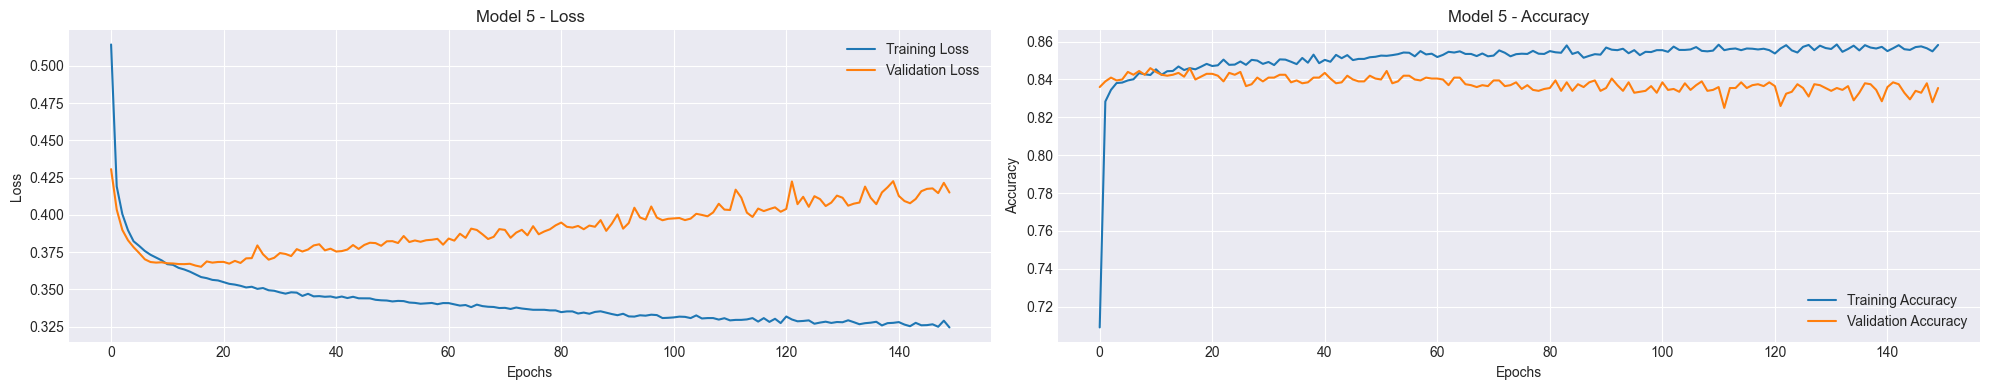

In [94]:
plot_learning_curves(model_5_history, 'Model 5')

#### MODEL WITH 32 + 16 + 8 + 4 + 2 + 1 NEURON

In [95]:
model_6 = Sequential()
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(16, activation='relu'))
model_6.add(Dense(8, activation='relu'))
model_6.add(Dense(4, activation='relu'))
model_6.add(Dense(2, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_6_checkpoint = ModelCheckpoint('model_6.h5', save_best_only=True)

model_6_history = model_6.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_val, y_val), callbacks=[model_6_checkpoint])

Epoch 1/300
1000/1000 [==============================] - 3s 2ms/step - loss: 0.4422 - accuracy: 0.7899 - val_loss: 0.3788 - val_accuracy: 0.8415
Epoch 2/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3772 - accuracy: 0.8331 - val_loss: 0.3690 - val_accuracy: 0.8415
Epoch 3/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3689 - accuracy: 0.8395 - val_loss: 0.3724 - val_accuracy: 0.8390
Epoch 4/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3656 - accuracy: 0.8406 - val_loss: 0.3673 - val_accuracy: 0.8430
Epoch 5/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3630 - accuracy: 0.8422 - val_loss: 0.3640 - val_accuracy: 0.8440
Epoch 6/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3602 - accuracy: 0.8435 - val_loss: 0.3677 - val_accuracy: 0.8385
Epoch 7/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3582 - accuracy: 0.8421 - val_loss: 0.3682 - val_ac

1000/1000 [==============================] - 2s 2ms/step - loss: 0.2959 - accuracy: 0.8674 - val_loss: 0.4752 - val_accuracy: 0.8255
Epoch 58/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2915 - accuracy: 0.8690 - val_loss: 0.4781 - val_accuracy: 0.8195
Epoch 59/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2912 - accuracy: 0.8692 - val_loss: 0.4993 - val_accuracy: 0.8290
Epoch 60/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2926 - accuracy: 0.8686 - val_loss: 0.4801 - val_accuracy: 0.8225
Epoch 61/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2897 - accuracy: 0.8680 - val_loss: 0.4751 - val_accuracy: 0.8210
Epoch 62/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2891 - accuracy: 0.8706 - val_loss: 0.5097 - val_accuracy: 0.8225
Epoch 63/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2899 - accuracy: 0.8708 - val_loss: 0.5053 - val_accuracy

1000/1000 [==============================] - 2s 2ms/step - loss: 0.2639 - accuracy: 0.8776 - val_loss: 0.6680 - val_accuracy: 0.8150
Epoch 114/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2641 - accuracy: 0.8796 - val_loss: 0.6345 - val_accuracy: 0.8180
Epoch 115/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2644 - accuracy: 0.8802 - val_loss: 0.6252 - val_accuracy: 0.8160
Epoch 116/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2673 - accuracy: 0.8775 - val_loss: 0.6236 - val_accuracy: 0.8135
Epoch 117/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2644 - accuracy: 0.8770 - val_loss: 0.6390 - val_accuracy: 0.8155
Epoch 118/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2638 - accuracy: 0.8813 - val_loss: 0.6646 - val_accuracy: 0.8210
Epoch 119/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2652 - accuracy: 0.8798 - val_loss: 0.6781 - val_ac

Epoch 169/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2504 - accuracy: 0.8869 - val_loss: 0.7847 - val_accuracy: 0.8140
Epoch 170/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2511 - accuracy: 0.8856 - val_loss: 0.8285 - val_accuracy: 0.8120
Epoch 171/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2486 - accuracy: 0.8876 - val_loss: 0.7959 - val_accuracy: 0.8190
Epoch 172/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2460 - accuracy: 0.8863 - val_loss: 0.7553 - val_accuracy: 0.8150
Epoch 173/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2449 - accuracy: 0.8894 - val_loss: 0.8266 - val_accuracy: 0.8230
Epoch 174/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2466 - accuracy: 0.8898 - val_loss: 0.8359 - val_accuracy: 0.8195
Epoch 175/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2534 - accuracy: 0.8854 - val_loss: 0

Epoch 225/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2352 - accuracy: 0.8942 - val_loss: 0.9038 - val_accuracy: 0.8160
Epoch 226/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2374 - accuracy: 0.8923 - val_loss: 0.9436 - val_accuracy: 0.8140
Epoch 227/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2430 - accuracy: 0.8895 - val_loss: 0.9731 - val_accuracy: 0.8210
Epoch 228/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2399 - accuracy: 0.8917 - val_loss: 0.9637 - val_accuracy: 0.8230
Epoch 229/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2350 - accuracy: 0.8919 - val_loss: 0.9356 - val_accuracy: 0.8050
Epoch 230/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2394 - accuracy: 0.8903 - val_loss: 0.9833 - val_accuracy: 0.8200
Epoch 231/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2359 - accuracy: 0.8924 - val_loss: 1

Epoch 281/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2293 - accuracy: 0.8997 - val_loss: 1.0063 - val_accuracy: 0.8140
Epoch 282/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2283 - accuracy: 0.8974 - val_loss: 0.9958 - val_accuracy: 0.8190
Epoch 283/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2361 - accuracy: 0.8956 - val_loss: 0.9817 - val_accuracy: 0.8095
Epoch 284/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2312 - accuracy: 0.8961 - val_loss: 1.0463 - val_accuracy: 0.8170
Epoch 285/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2276 - accuracy: 0.8976 - val_loss: 1.0458 - val_accuracy: 0.8225
Epoch 286/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2310 - accuracy: 0.8944 - val_loss: 0.9675 - val_accuracy: 0.8020
Epoch 287/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2358 - accuracy: 0.8940 - val_loss: 0

In [96]:
model_6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (8, 32)                   544       
                                                                 
 dense_45 (Dense)            (8, 16)                   528       
                                                                 
 dense_46 (Dense)            (8, 8)                    136       
                                                                 
 dense_47 (Dense)            (8, 4)                    36        
                                                                 
 dense_48 (Dense)            (8, 2)                    10        
                                                                 
 dense_49 (Dense)            (8, 1)                    3         
                                                                 
Total params: 1,257
Trainable params: 1,257
Non-train

In [97]:
training_accuracy = model_6_history.history['accuracy']
validation_accuracy = model_6_history.history['val_accuracy']

print(f"Training Accuracy: {training_accuracy[-1]*100:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]*100:.4f}")

Training Accuracy: 89.8875
Validation Accuracy: 81.1000


In [98]:
model_6_y_pred = (model_6.predict(X_val) > 0.5).astype(int)
model_6_accuracy = accuracy_score(y_val, model_6_y_pred)
model_6_classification_report_str = classification_report(y_val, model_6_y_pred)

print(f"Accuracy: {model_6_accuracy :.2%}")
print("\nClassification Report:\n", model_6_classification_report_str)

63/63 [==============================] - 0s 1ms/step
Accuracy: 81.10%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1392
         1.0       0.68      0.72      0.70       608

    accuracy                           0.81      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.81      0.81      0.81      2000



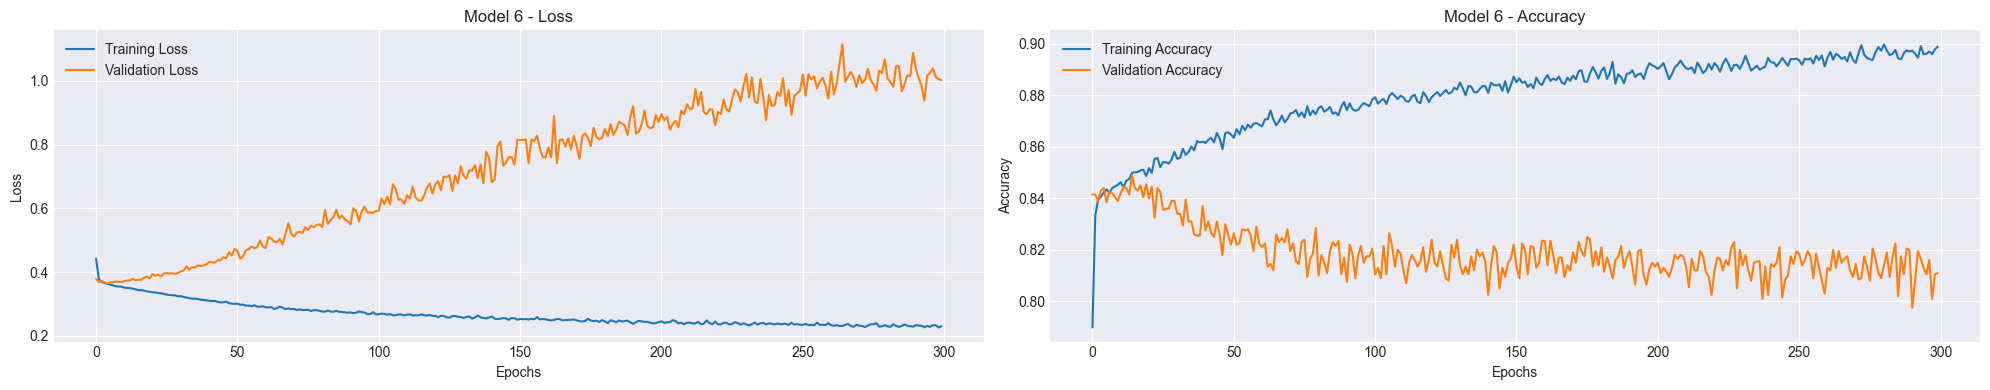

In [99]:
plot_learning_curves(model_6_history, 'Model 6')

### BEST MODEL: 2 + 1 NEURON ROC & AUC

313/313 [==============================] - 0s 993us/step


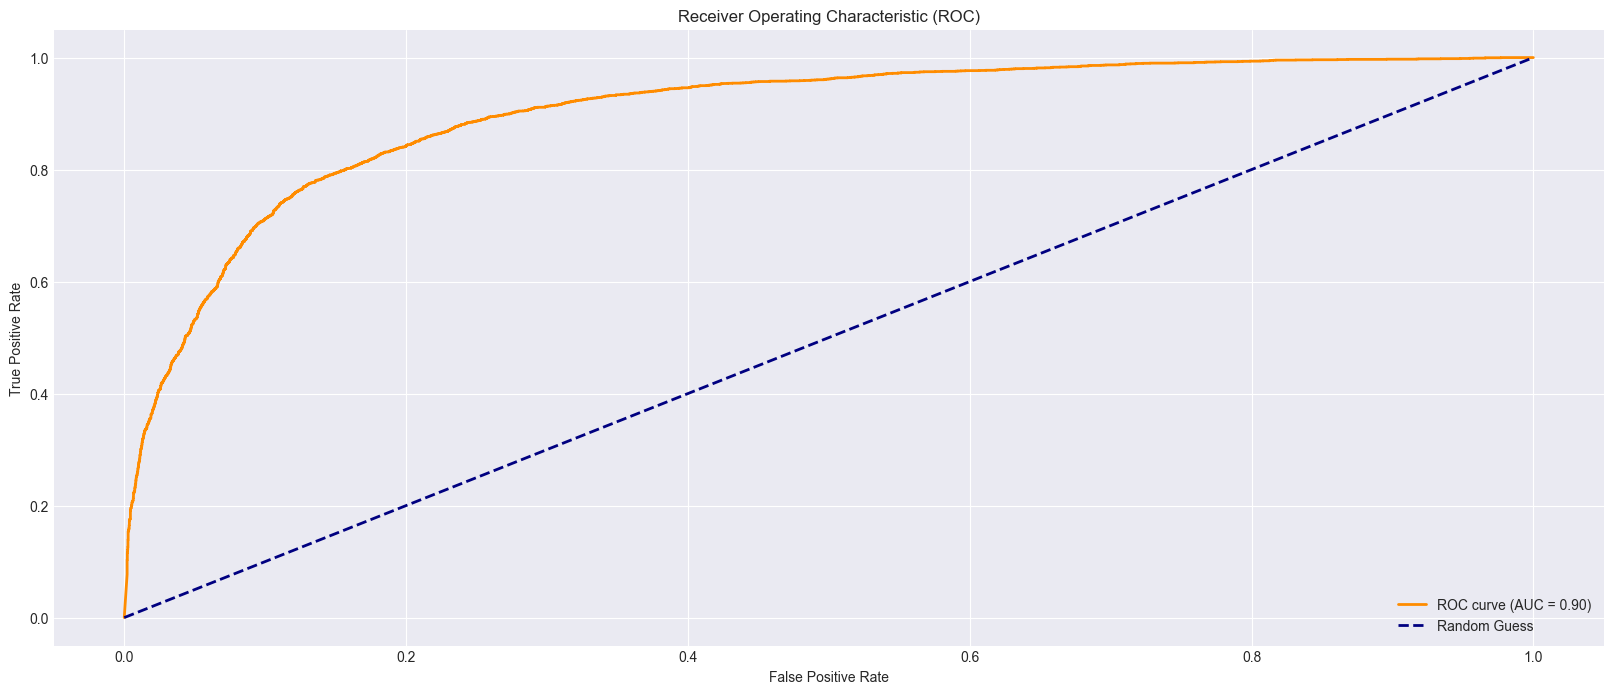

In [100]:
y_pred_proba = model_2.predict(X)

fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(20, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### GRADUATE REQUIREMENT

In [101]:
def create_custom_model(total_neurons, checkpoint_path, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    model = Sequential()

    num_layers = int(round(log2(total_neurons) + 0.5))

    neurons = total_neurons

    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        neurons = max(1, neurons // 2)

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[checkpoint])

    model_y_pred = (model.predict(X_val) > 0.5).astype(int)
    model_accuracy = accuracy_score(y_val, model_y_pred)
    model_classification_report_str = classification_report(y_val, model_y_pred)
    print("/n/n -------------------------------------------------------------------------------/n/n")
    print(f"Training Accuracy: {history.history['accuracy'][-1]*100:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100:.4f}")
    # print(f"Accuracy: {model_accuracy:.2%}")
    print("\nClassification Report:\n", model_classification_report_str)

    return model, history

# Example usage:
total_neurons = 2
checkpoint_path = 'model_checkpoint.h5'

model, history = create_custom_model(total_neurons, checkpoint_path, X_train, y_train, X_val, y_val)

Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6784 - accuracy: 0.6478 - val_loss: 0.6387 - val_accuracy: 0.7525
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 0.6051 - accuracy: 0.7846 - val_loss: 0.5731 - val_accuracy: 0.8035
Epoch 3/50
250/250 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.8086 - val_loss: 0.5255 - val_accuracy: 0.8165
Epoch 4/50
250/250 [==============================] - 0s 2ms/step - loss: 0.5105 - accuracy: 0.8163 - val_loss: 0.4903 - val_accuracy: 0.8185
Epoch 5/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.8214 - val_loss: 0.4641 - val_accuracy: 0.8260
Epoch 6/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.8255 - val_loss: 0.4438 - val_accuracy: 0.8310
Epoch 7/50
250/250 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.8311 - val_loss: 0.4290 - val_accuracy: 0.8360
Epoch 

### FEATURE IMPORTANCE AND REDUCTION

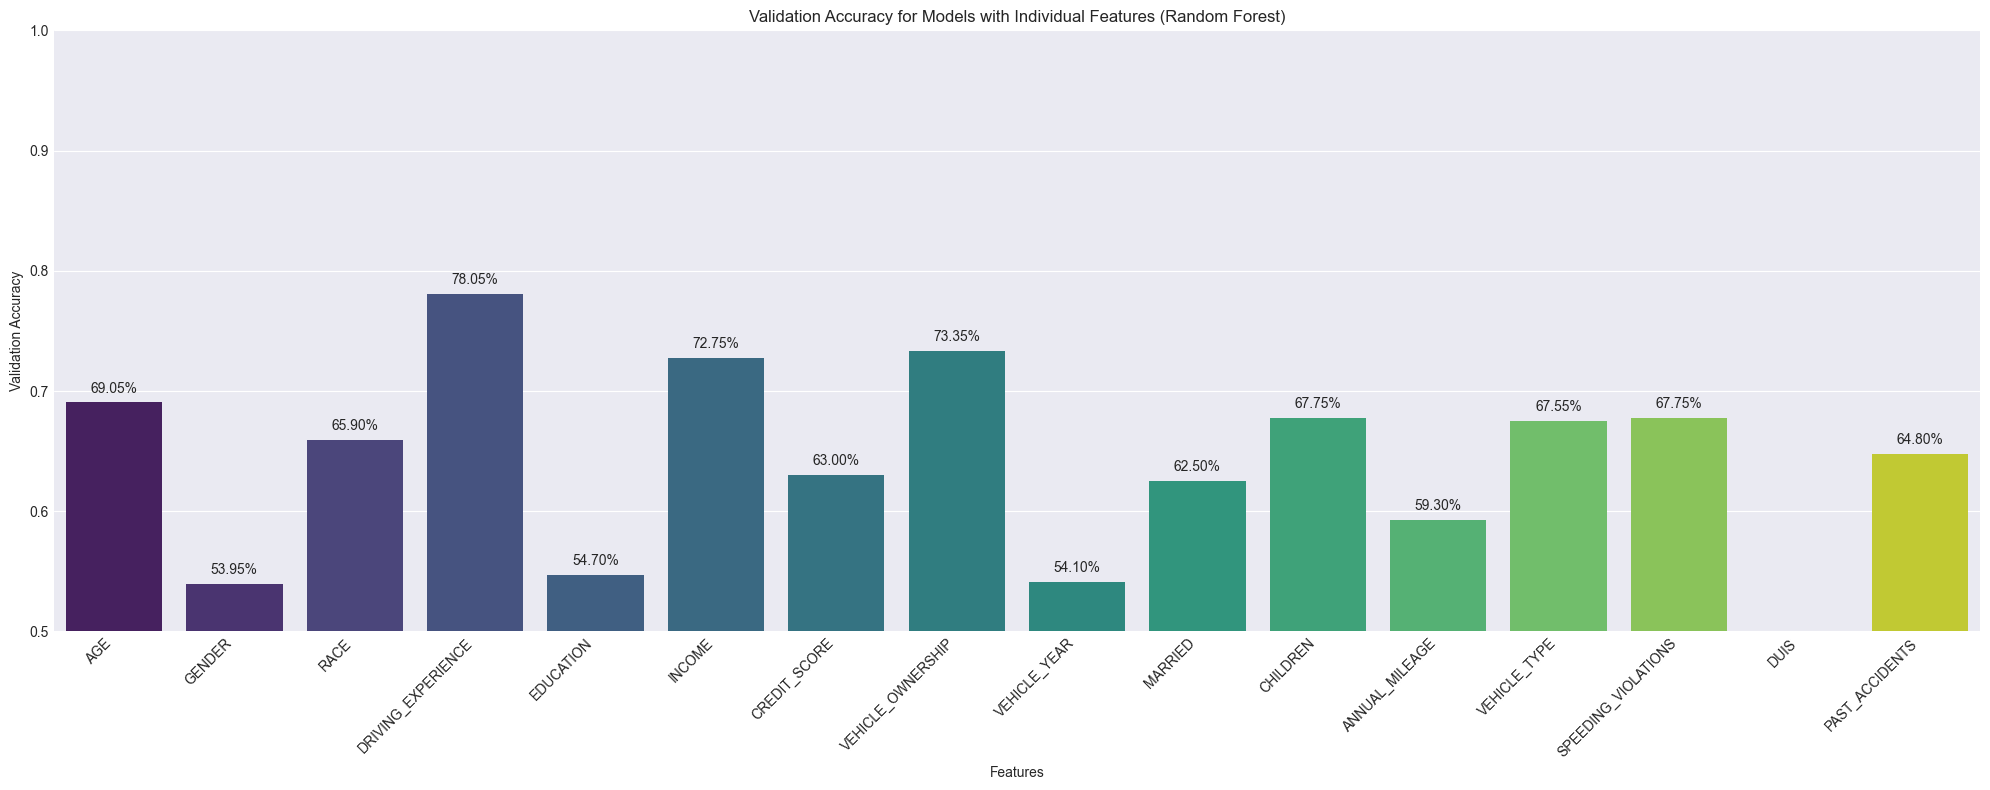

In [102]:
feature_accuracies = {}

for feature in X_train.columns:

    X_train_single_feature = X_train[[feature]]
    X_val_single_feature = X_val[[feature]]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    rf_model.fit(X_train_single_feature, y_train)

    y_pred = rf_model.predict(X_val_single_feature)

    accuracy = accuracy_score(y_val, y_pred)
    feature_accuracies[feature] = accuracy

accuracy_df = pd.DataFrame(list(feature_accuracies.items()), columns=['Feature', 'Accuracy'])

plt.figure(figsize=(20, 8))
ax = sns.barplot(x='Feature', y='Accuracy', data=accuracy_df, palette='viridis')
plt.ylim(0.5, 1.0)
plt.xlabel('Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Models with Individual Features (Random Forest)')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()


In [103]:
most_important_feature = max(feature_accuracies, key=feature_accuracies.get)

print(f"The most important feature is '{most_important_feature}' with accuracy: {feature_accuracies[most_important_feature]*100:.2f}%")

The most important feature is 'DRIVING_EXPERIENCE' with accuracy: 78.05%


In [104]:
def train_and_evaluate_model(features_subset, model_name):

    X_train_subset = X_train[list(features_subset)]
    X_val_subset = X_val[list(features_subset)]

    rf_model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')

    rf_model.fit(X_train_subset, y_train)

    y_pred = rf_model.predict(X_val_subset)

    accuracy = accuracy_score(y_val, y_pred)
    subset_accuracies[model_name] = accuracy
    print(f"\nModel {model_name}\n")
    print(f"Features: {', '.join(features_subset)}")
    print(f"Removed features: {', '.join(set(sorted_features) - set(features_subset))}")
    print(f"Validation Accuracy: {accuracy:.4f}\n")

subset_accuracies = {}

sorted_features = sorted(feature_accuracies, key=feature_accuracies.get)

for i in range(len(sorted_features)):
    features_subset_combinations = combinations(sorted_features[i:], len(sorted_features) - i)

    for idx, features_subset in enumerate(features_subset_combinations, 1):
        model_name = f"Model_{i+1}_{idx}"
        train_and_evaluate_model(features_subset, model_name)

subset_accuracy_df = pd.DataFrame(list(subset_accuracies.items()), columns=['Model', 'Validation Accuracy'])


Model Model_1_1

Features: DUIS, GENDER, VEHICLE_YEAR, EDUCATION, ANNUAL_MILEAGE, MARRIED, CREDIT_SCORE, PAST_ACCIDENTS, RACE, VEHICLE_TYPE, CHILDREN, SPEEDING_VIOLATIONS, AGE, INCOME, VEHICLE_OWNERSHIP, DRIVING_EXPERIENCE
Removed features: 
Validation Accuracy: 0.8345


Model Model_2_1

Features: GENDER, VEHICLE_YEAR, EDUCATION, ANNUAL_MILEAGE, MARRIED, CREDIT_SCORE, PAST_ACCIDENTS, RACE, VEHICLE_TYPE, CHILDREN, SPEEDING_VIOLATIONS, AGE, INCOME, VEHICLE_OWNERSHIP, DRIVING_EXPERIENCE
Removed features: DUIS
Validation Accuracy: 0.8300


Model Model_3_1

Features: VEHICLE_YEAR, EDUCATION, ANNUAL_MILEAGE, MARRIED, CREDIT_SCORE, PAST_ACCIDENTS, RACE, VEHICLE_TYPE, CHILDREN, SPEEDING_VIOLATIONS, AGE, INCOME, VEHICLE_OWNERSHIP, DRIVING_EXPERIENCE
Removed features: DUIS, GENDER
Validation Accuracy: 0.8110


Model Model_4_1

Features: EDUCATION, ANNUAL_MILEAGE, MARRIED, CREDIT_SCORE, PAST_ACCIDENTS, RACE, VEHICLE_TYPE, CHILDREN, SPEEDING_VIOLATIONS, AGE, INCOME, VEHICLE_OWNERSHIP, DRIVING_EXP

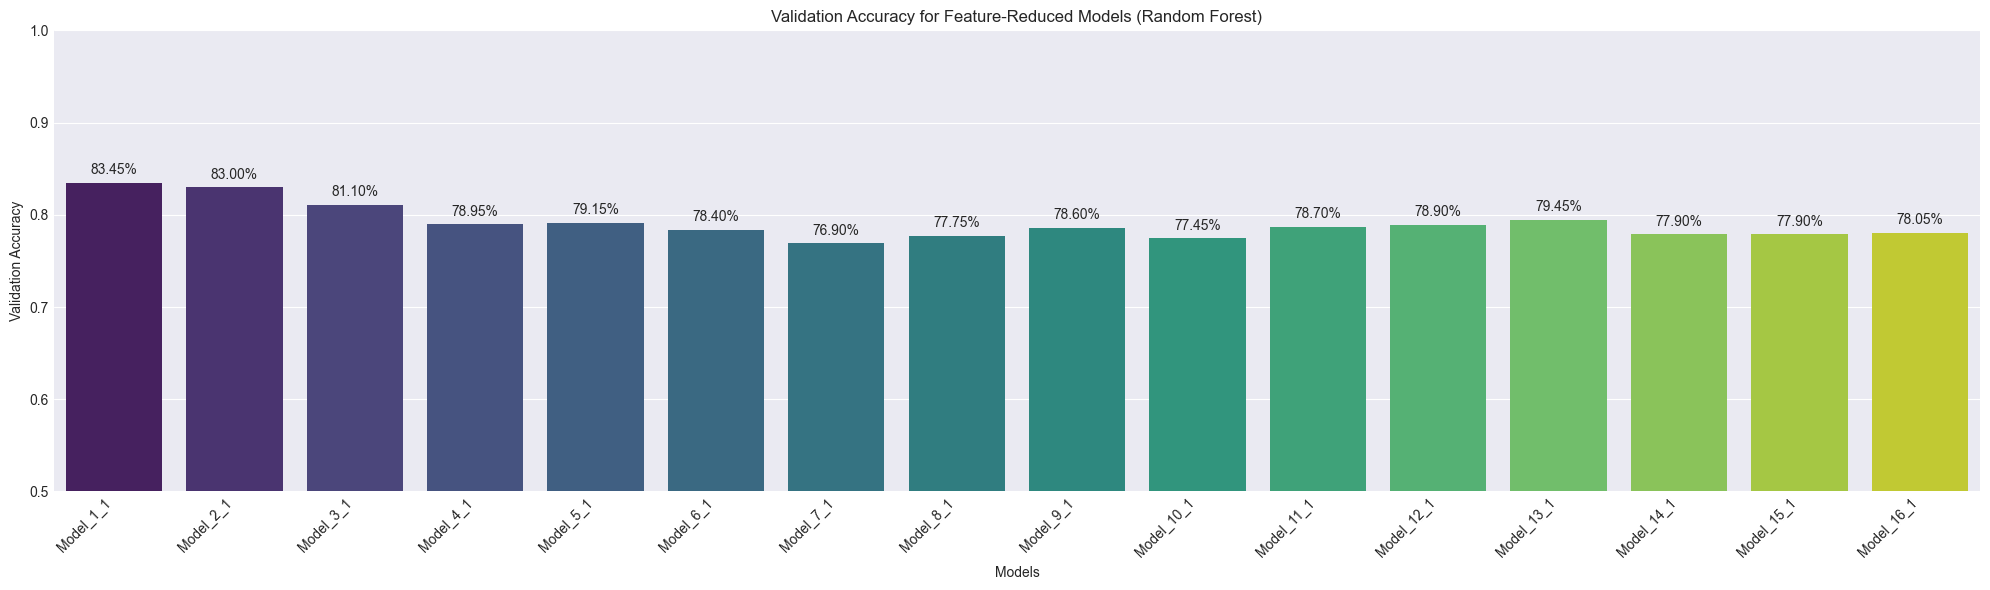

In [105]:
plt.figure(figsize=(20, 6))

barplot = sns.barplot(x='Model', y='Validation Accuracy', data=subset_accuracy_df, palette='viridis')

for p in barplot.patches:
    barplot.annotate(f"{p.get_height() * 100:.2f}%",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.ylim(0.5, 1.0)
plt.xlabel('Models')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Feature-Reduced Models (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()